In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import comet_ml
from comet_ml import Experiment

In [3]:
import os, sys
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [4]:
sys.path.insert(0,'../training')
from manifoldembedder import *
from sklearn.manifold import TSNE
import umap 

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

In [6]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt


In [7]:
basedir = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs'

In [8]:
file_dict = {'train':os.path.join(basedir, 'Gridpack_jettrain_16part_merged.pt'),
             'val':os.path.join(basedir, 'Gridpack_jetval_16part_merged.pt'),
             'test':None,
             'predict':os.path.join(basedir, 'Gridpack_jetpredict_16part_merged.pt')}

In [41]:
type(mix_original_set)

manifoldembedder.JetPredictDataset

In [9]:
mix_original_set = torch.load(os.path.join(basedir, 'taus_Gridpack_jetpair_predict.pt'))
mix_loader = DataLoader(mix_original_set, batch_size=2500, shuffle=False)
result = np.empty((0,48))
predict_label = np.array([])

for batch in tqdm(mix_loader):


    result = np.vstack((result, batch[0].cpu().numpy().reshape(-1,48)))
    predict_label = np.concatenate([predict_label, batch[1].cpu().numpy()])

100%|██████████| 280/280 [00:15<00:00, 17.53it/s]


In [10]:
result.shape

(700000, 48)

In [11]:
predict_label.shape

(700000,)

In [12]:
predict_label[-10]

6.0

In [13]:
with open(f'/nobackup/users/sangeon/datasets/jetGridpack/jetpairs/taus_Gridpack_jetpair_predict_extrafeats.pickle','rb') as handle:
    extrafeats = pickle.load(handle)

In [14]:
extrafeats.shape

(700000, 14)

In [15]:
column_names = ['particle 0 pt', 'particle 0 eta', 'particle 0 phi', 'particle 1 pt',
       'particle 1 eta', 'particle 1 phi', 'particle 2 pt', 'particle 2 eta',
       'particle 2 phi', 'particle 3 pt', 'particle 3 eta', 'particle 3 phi',
       'particle 4 pt', 'particle 4 eta', 'particle 4 phi', 'particle 5 pt',
       'particle 5 eta', 'particle 5 phi', 'particle 6 pt', 'particle 6 eta',
       'particle 6 phi', 'particle 7 pt', 'particle 7 eta', 'particle 7 phi',
       'particle 8 pt', 'particle 8 eta', 'particle 8 phi', 'particle 9 pt',
       'particle 9 eta', 'particle 9 phi', 'particle 10 pt', 'particle 10 eta',
       'particle 10 phi', 'particle 11 pt', 'particle 11 eta',
       'particle 11 phi', 'particle 12 pt', 'particle 12 eta',
       'particle 12 phi', 'particle 13 pt', 'particle 13 eta',
       'particle 13 phi', 'particle 14 pt', 'particle 14 eta',
       'particle 14 phi', 'particle 15 pt', 'particle 15 eta',
       'particle 15 phi', 'jet pT', 'jet eta', 'jet phi', 'jet mass',
       'jet mmdt', 'jet softdrop', 'jet tau21', 'jet tau32', 'jet tau43',
       'jet tau54', 'jet tau65', 'jet tau76', 'jet tau87',
       'jet sqrt_t1_b2_t1_b2']

In [10]:
rawjetdir = '/nobackup/users/sangeon/datasets/jetGridpack/rawjets/'
type_arr  = [['QCD','QCD',''],['2p','twoprong','_25'],['2p','twoprong','_170'],['3p','threeprong','_25'],['3p','threeprong','_170'],['4p','fourprong','_170'],['4p','fourprong','_400']]
set_list = []
name_list = ['QCD','2p25','2p170','3p25','3p170','4p170','4p400']

results = np.empty((0,54))
predict_label = np.empty((0))
for i, (name, jettype) in enumerate(zip(name_list, type_arr)):
    df = pd.read_hdf(os.path.join(rawjetdir,jettype[0],f'{jettype[1]}{jettype[2]}.h5'))
    data = df.values[:,:54]
    print(data.shape)
    data = data[:1000]
    results = np.vstack([results, data])
    print(df.values.shape[0])
    print(name, jettype)
    predict_label = np.concatenate([predict_label, np.repeat(i, data.shape[0])])

(1947882, 54)
1947882
QCD ['QCD', 'QCD', '']
(1987432, 54)
1987432
2p25 ['2p', 'twoprong', '_25']
(1588303, 54)
1588303
2p170 ['2p', 'twoprong', '_170']
(1944347, 54)
1944347
3p25 ['3p', 'threeprong', '_25']
(1364865, 54)
1364865
3p170 ['3p', 'threeprong', '_170']
(207456, 54)
207456
4p170 ['4p', 'fourprong', '_170']
(187644, 54)
187644
4p400 ['4p', 'fourprong', '_400']


In [16]:
result.shape

(700000, 48)

In [17]:
index_slices = np.r_[0:3000, 100000:103000, 200000:203000, 300000:303000, 400000:403000, 500000:503000,600000:603000]

In [18]:
predict_label[index_slices].shape

(21000,)

In [19]:
sliced_result = result[index_slices]

In [20]:
sliced_label = predict_label[index_slices]

In [21]:
sliced_feats = extrafeats[index_slices]

In [26]:
name_list = ['QCD','2p25','2p170','3p25','3p170','4p170','4p400']


In [22]:
sliced_result.shape

(21000, 48)

In [23]:
tsne = TSNE(n_components=2, random_state=0)

In [24]:
X_2d = tsne.fit_transform(sliced_result)

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


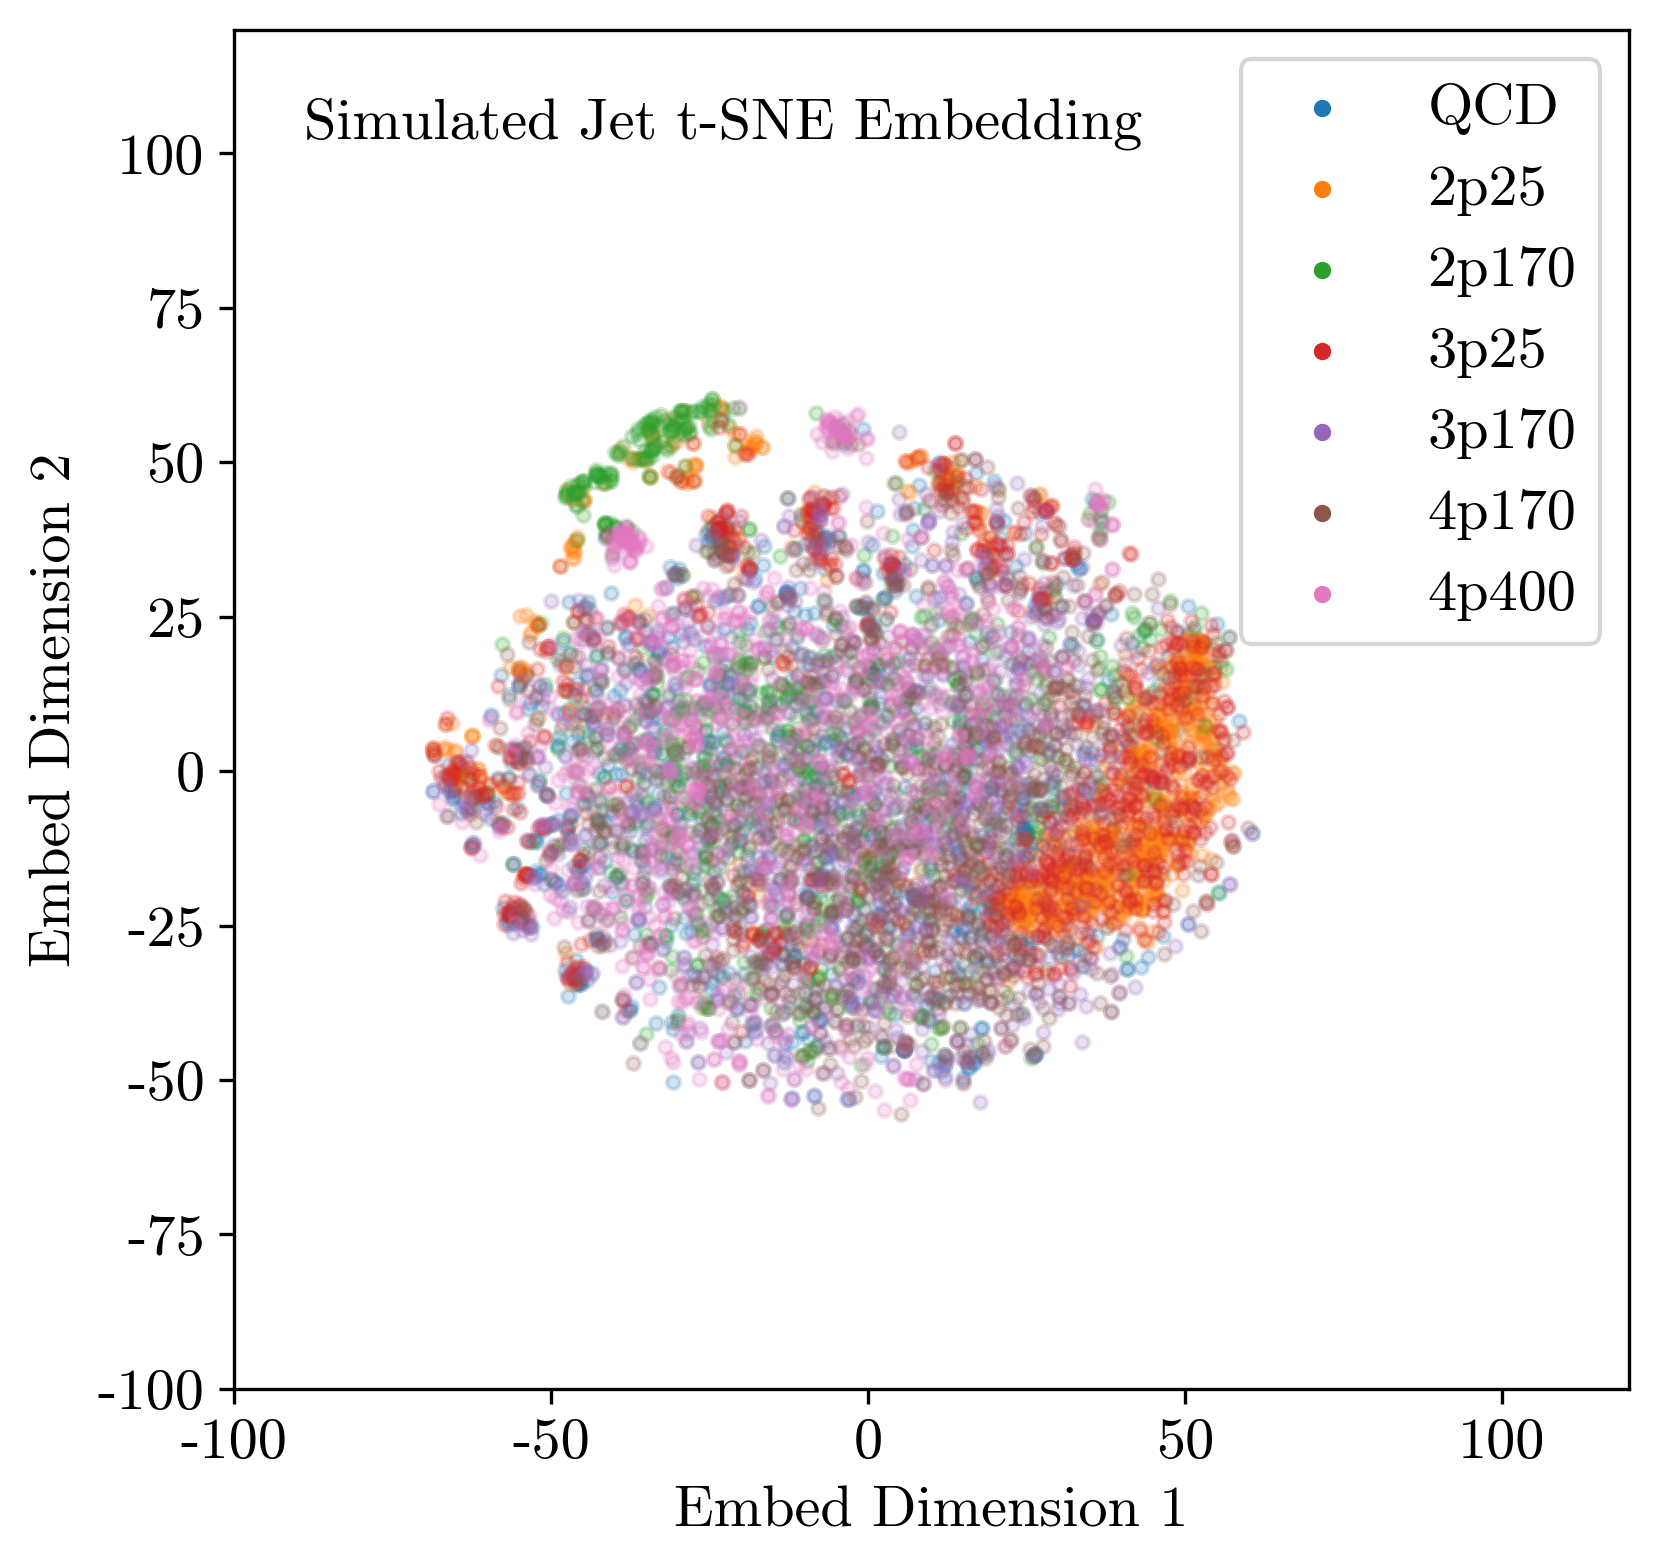

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(X_2d[sliced_label==i][:1000,0],X_2d[sliced_label==i][:1000,1],s=10,alpha=0.20,label=name_list[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-100,120])
ax.set_ylim([-100,120])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax.transAxes)    

#ax.set_title('t-SNE Embedding')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.pdf')

1.0 1.266755077937008e-51
1.0 2.23462749145477e-112
1.0 1.3433503921847444e-90
1.0 2.1221400150411716e-63
1.0 2.583083405851332e-57
1.0 1.837184762460763e-61
1.0 3.563433549252164e-63


Text(0.05, 0.92, 'Simulated Jet t-SNE Embedding')

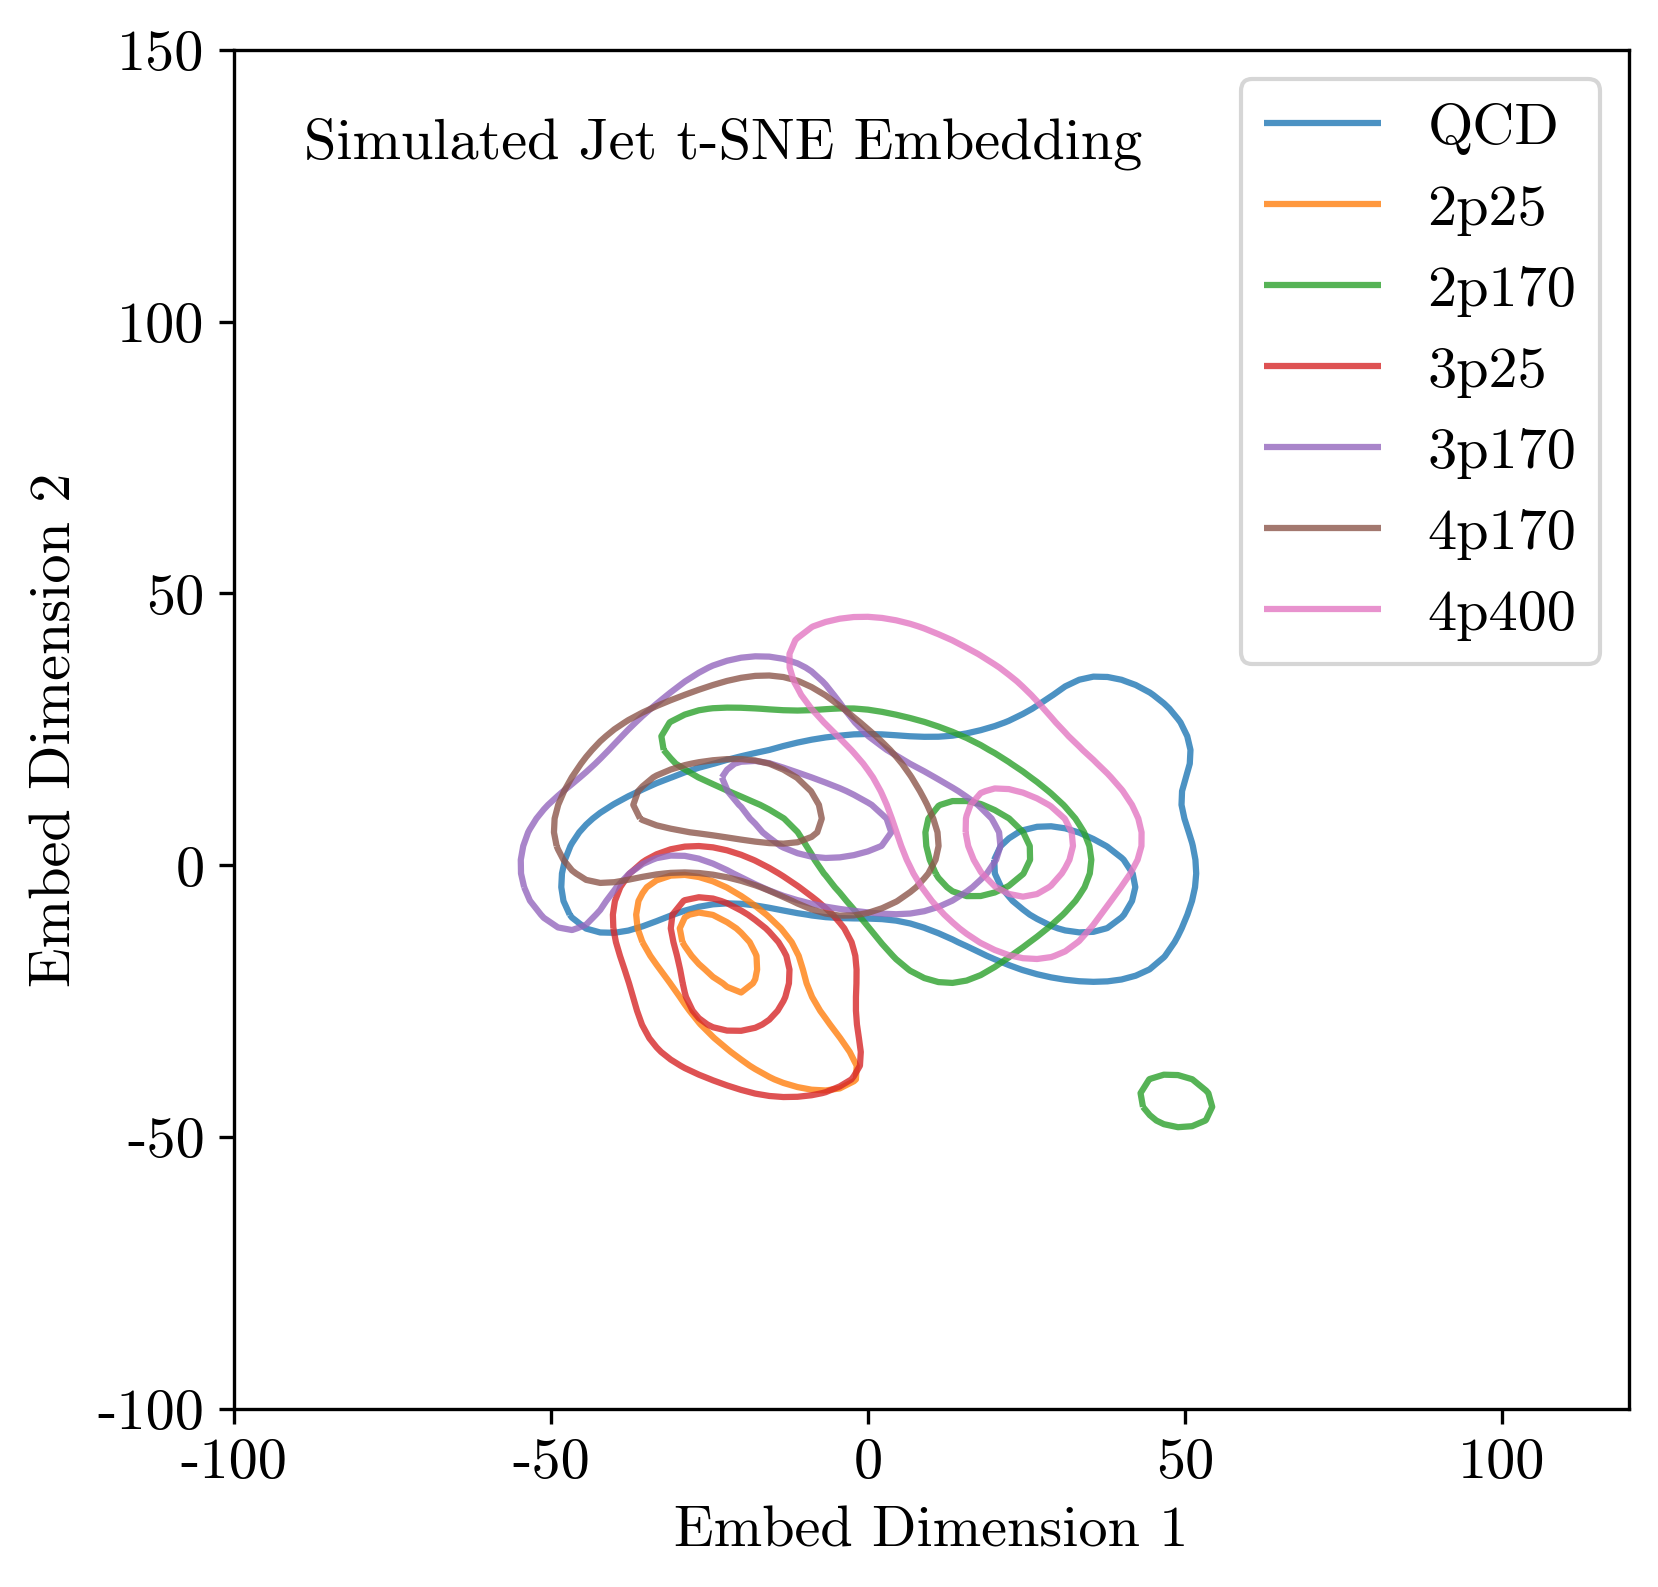

In [55]:
from sklearn.neighbors import KernelDensity
from scipy import interpolate

def kde2D(x, y, xrange, yrange, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[xrange[0]:xrange[1]:xbins, 
                      yrange[0]:yrange[1]:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [56]:
def plot_KDE_cdf_contour(ax, embedding, label, whichlabel, xrange, yrange, bandwidth, cdfval, color):

    xx, yy, zz = kde2D(embedding[label==whichlabel][:,0], embedding[label==whichlabel][:,1], xrange, yrange, bandwidth= bandwidth, kernel='gaussian')
    hist = zz/zz.sum()
    n = 1000
    t = np.linspace(0, hist.max(), n)
    integral = ((hist >= t[:, None, None]) * hist).sum(axis=(1,2))
    f = interpolate.interp1d(integral, t)

    t_contours = f(np.array(cdfval))
    
    #ax.imshow(hist.T, origin='lower', extent=[-0.1, 0.4, -0.05, 0.35], cmap="gray",aspect='auto')
    CS = ax.contour(hist.T, t_contours, extent=[xrange[0],xrange[1], yrange[0],yrange[1]],colors=color, alpha=0.8)
    
    #fig.set_size_inches(8, 8)
    return CS
    

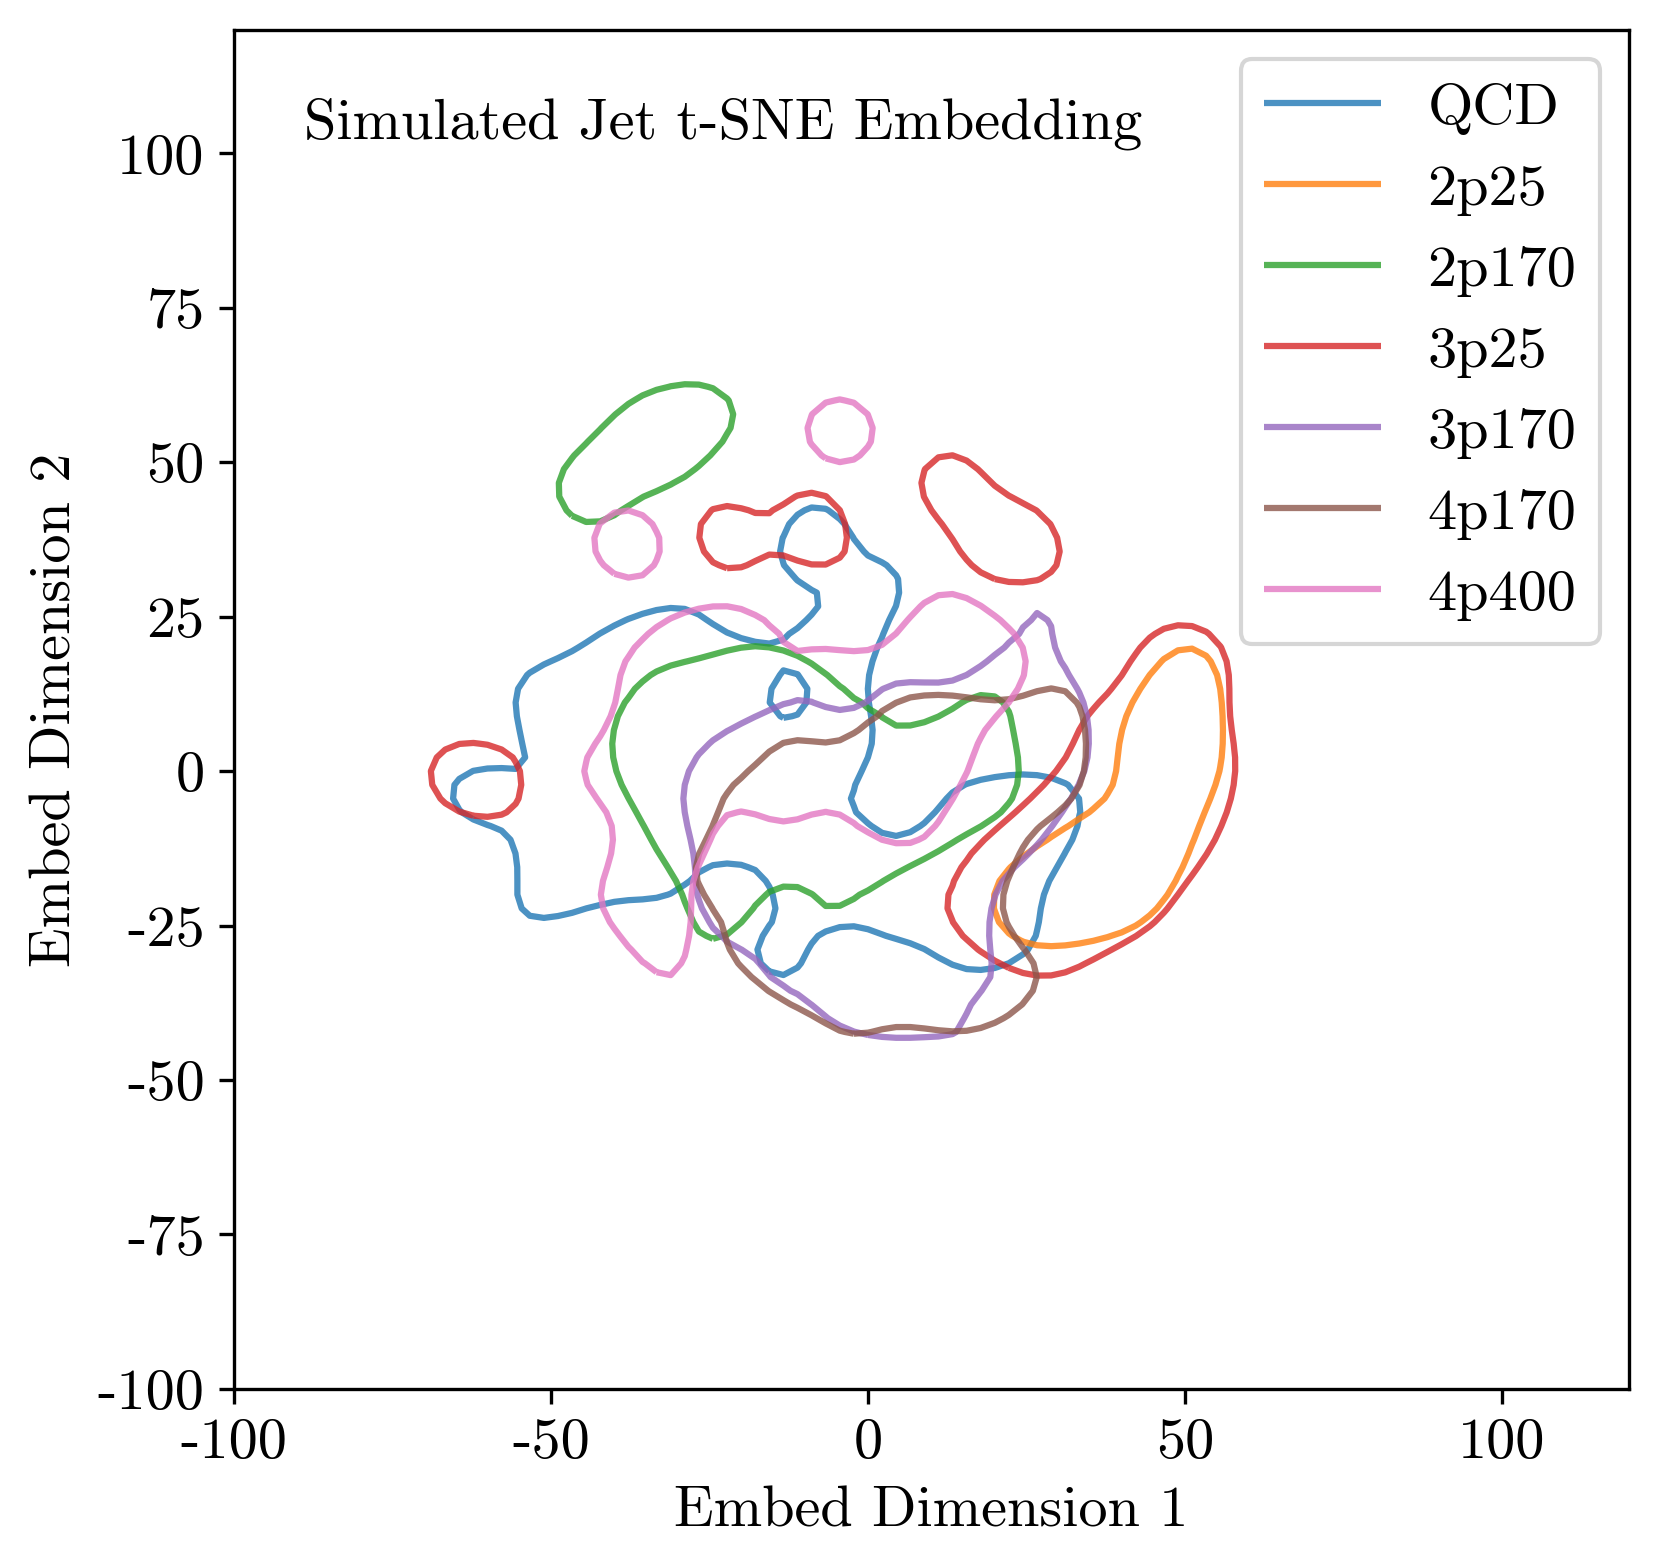

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
lines = []
xrange = [-100,120]
yrange = [-100,120]
for i in range(0,7):
    CS = plot_KDE_cdf_contour(ax, X_2d, sliced_label, i, xrange, yrange, 5, [0.5], f'C{i}')
    lines.append(CS.collections[0])


ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.legend(lines, namelist)
#ax.set_title('Simulated Jet Embedding')    
ax.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax.transAxes)    

fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.pdf')









In [23]:

%time X_2d = tsne.fit_transform(results[:,:48])

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 1min 53s, sys: 1.17 s, total: 1min 54s
Wall time: 42.4 s


In [13]:
predict_label

array([0., 0., 0., ..., 6., 6., 6.])

In [24]:
X_2d

array([[-14.871328 , -72.67972  ],
       [ -6.0803695, -27.721329 ],
       [  3.2844195, -60.29999  ],
       ...,
       [ 89.22204  ,  32.016056 ],
       [-43.854023 , -30.90524  ],
       [-52.369404 , -42.194073 ]], dtype=float32)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7000 but corresponding boolean dimension is 700000

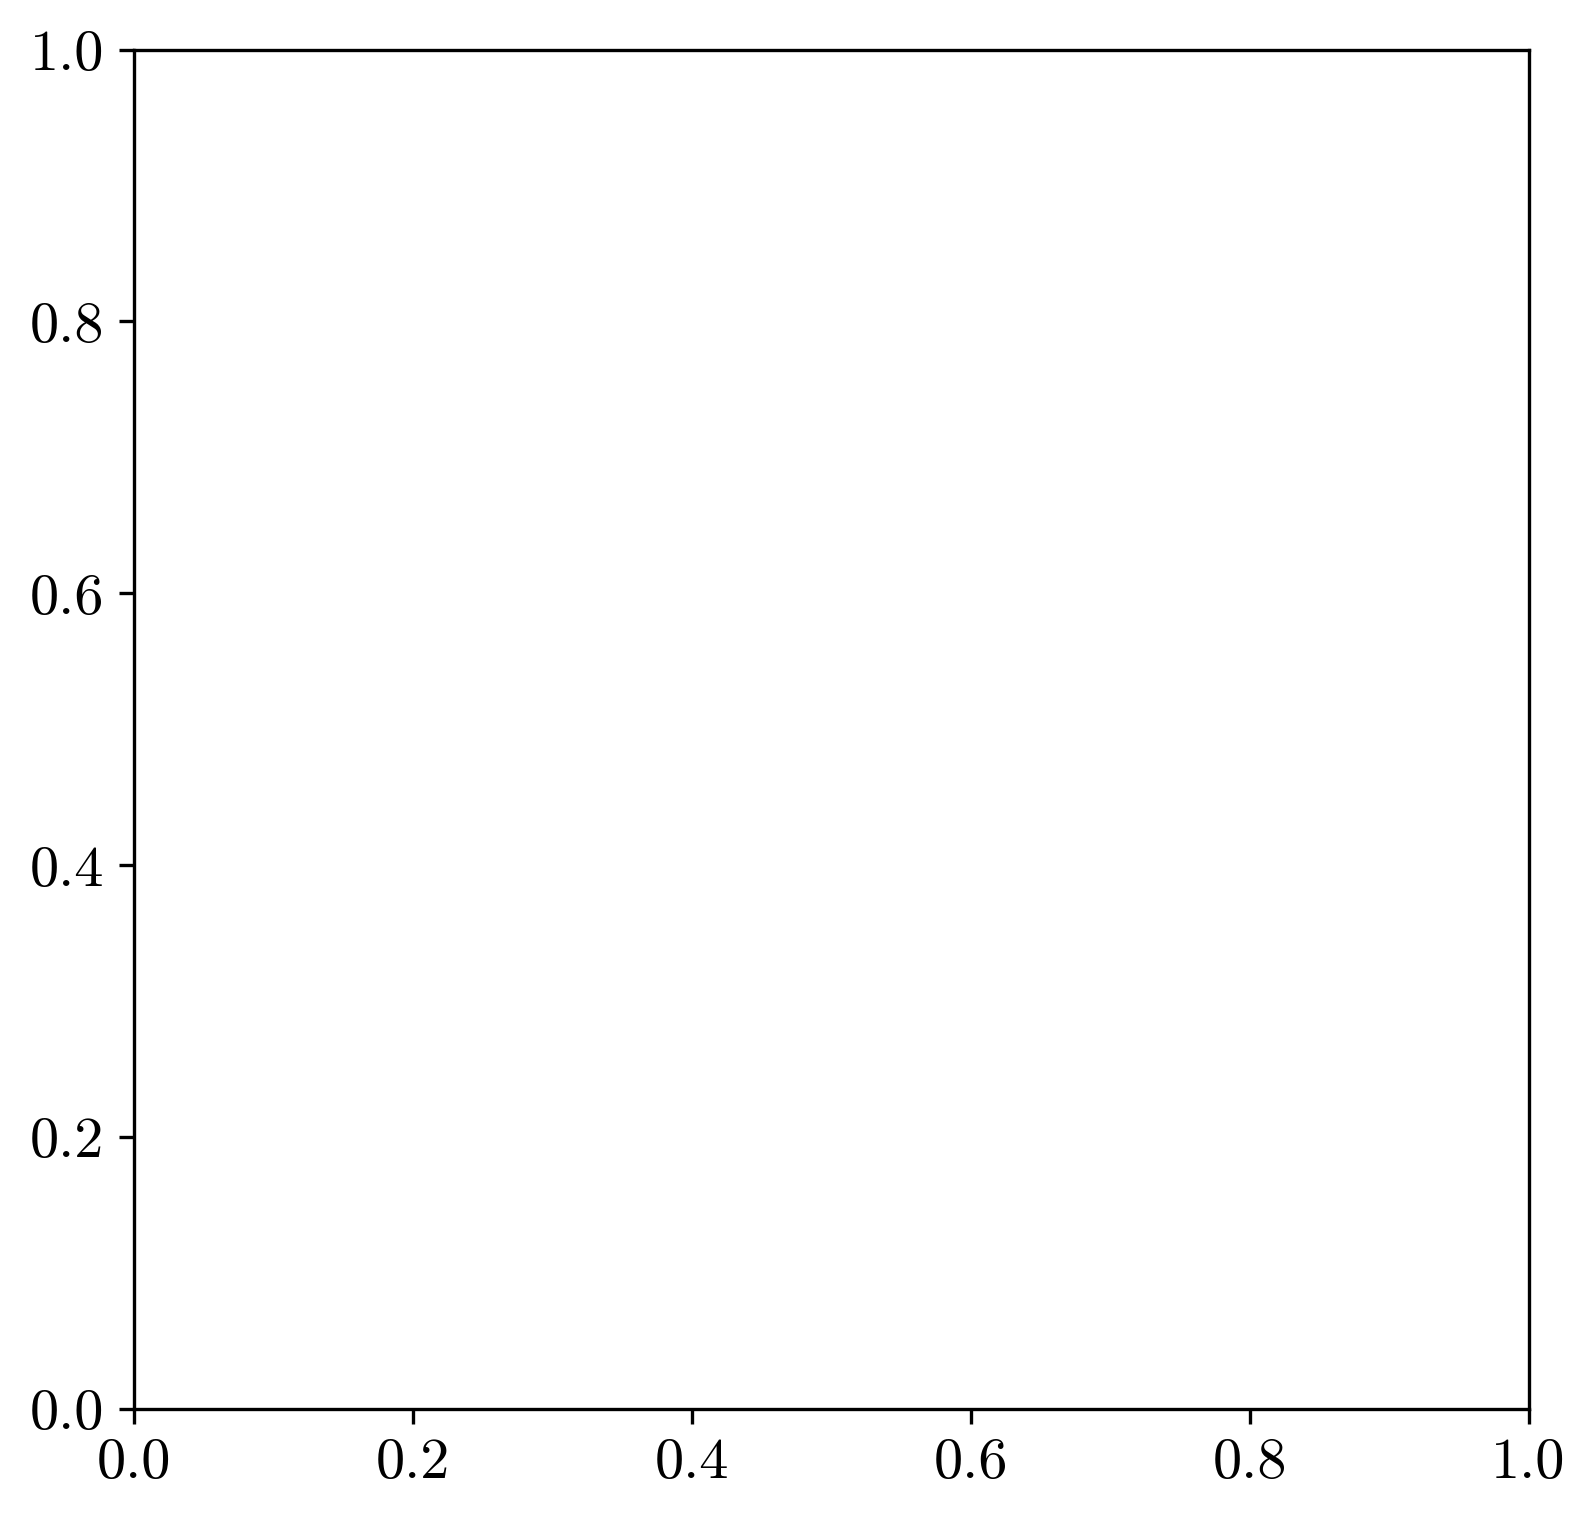

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(X_2d[predict_label==i][:1000,0],X_2d[predict_label==i][:1000,1],s=10,alpha=0.20,label=name_list[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-100,120])
ax.set_ylim([-100,150])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax.transAxes)    

#ax.set_title('t-SNE Embedding')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.png')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ScatterPlot.pdf')

In [174]:
from scipy import stats

def plot_kde(ax, embedding, label, xrange, yrange, npoints, whichlabel, color):
    #xmin = embedding[label==whichlabel][:,0].min()
    #xmax = embedding[label==whichlabel][:,0].max()
    #ymin = embedding[label==whichlabel][:,1].min()
    #ymax = embedding[label==whichlabel][:,1].max()
    xmin, xmax = xrange
    ymin, ymax = yrange
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    kernel = stats.gaussian_kde(embedding[label==whichlabel][:npoints].T)
    Z = np.reshape(kernel(positions).T, X.shape)
    Z /= Z.max()
    print(Z.max(),Z.min())
    #ax.imshow(np.rot90(Z),cmap='Blues' , extent=[xmin, xmax, ymin, ymax])
    CS = ax.contour(X,Y,Z,levels=[0.5],colors=color, alpha=0.8)
    #ax.contour(X,Y,Z,levels=1,colors=color)
    return CS


IndexError: boolean index did not match indexed array along dimension 0; dimension is 21000 but corresponding boolean dimension is 700000

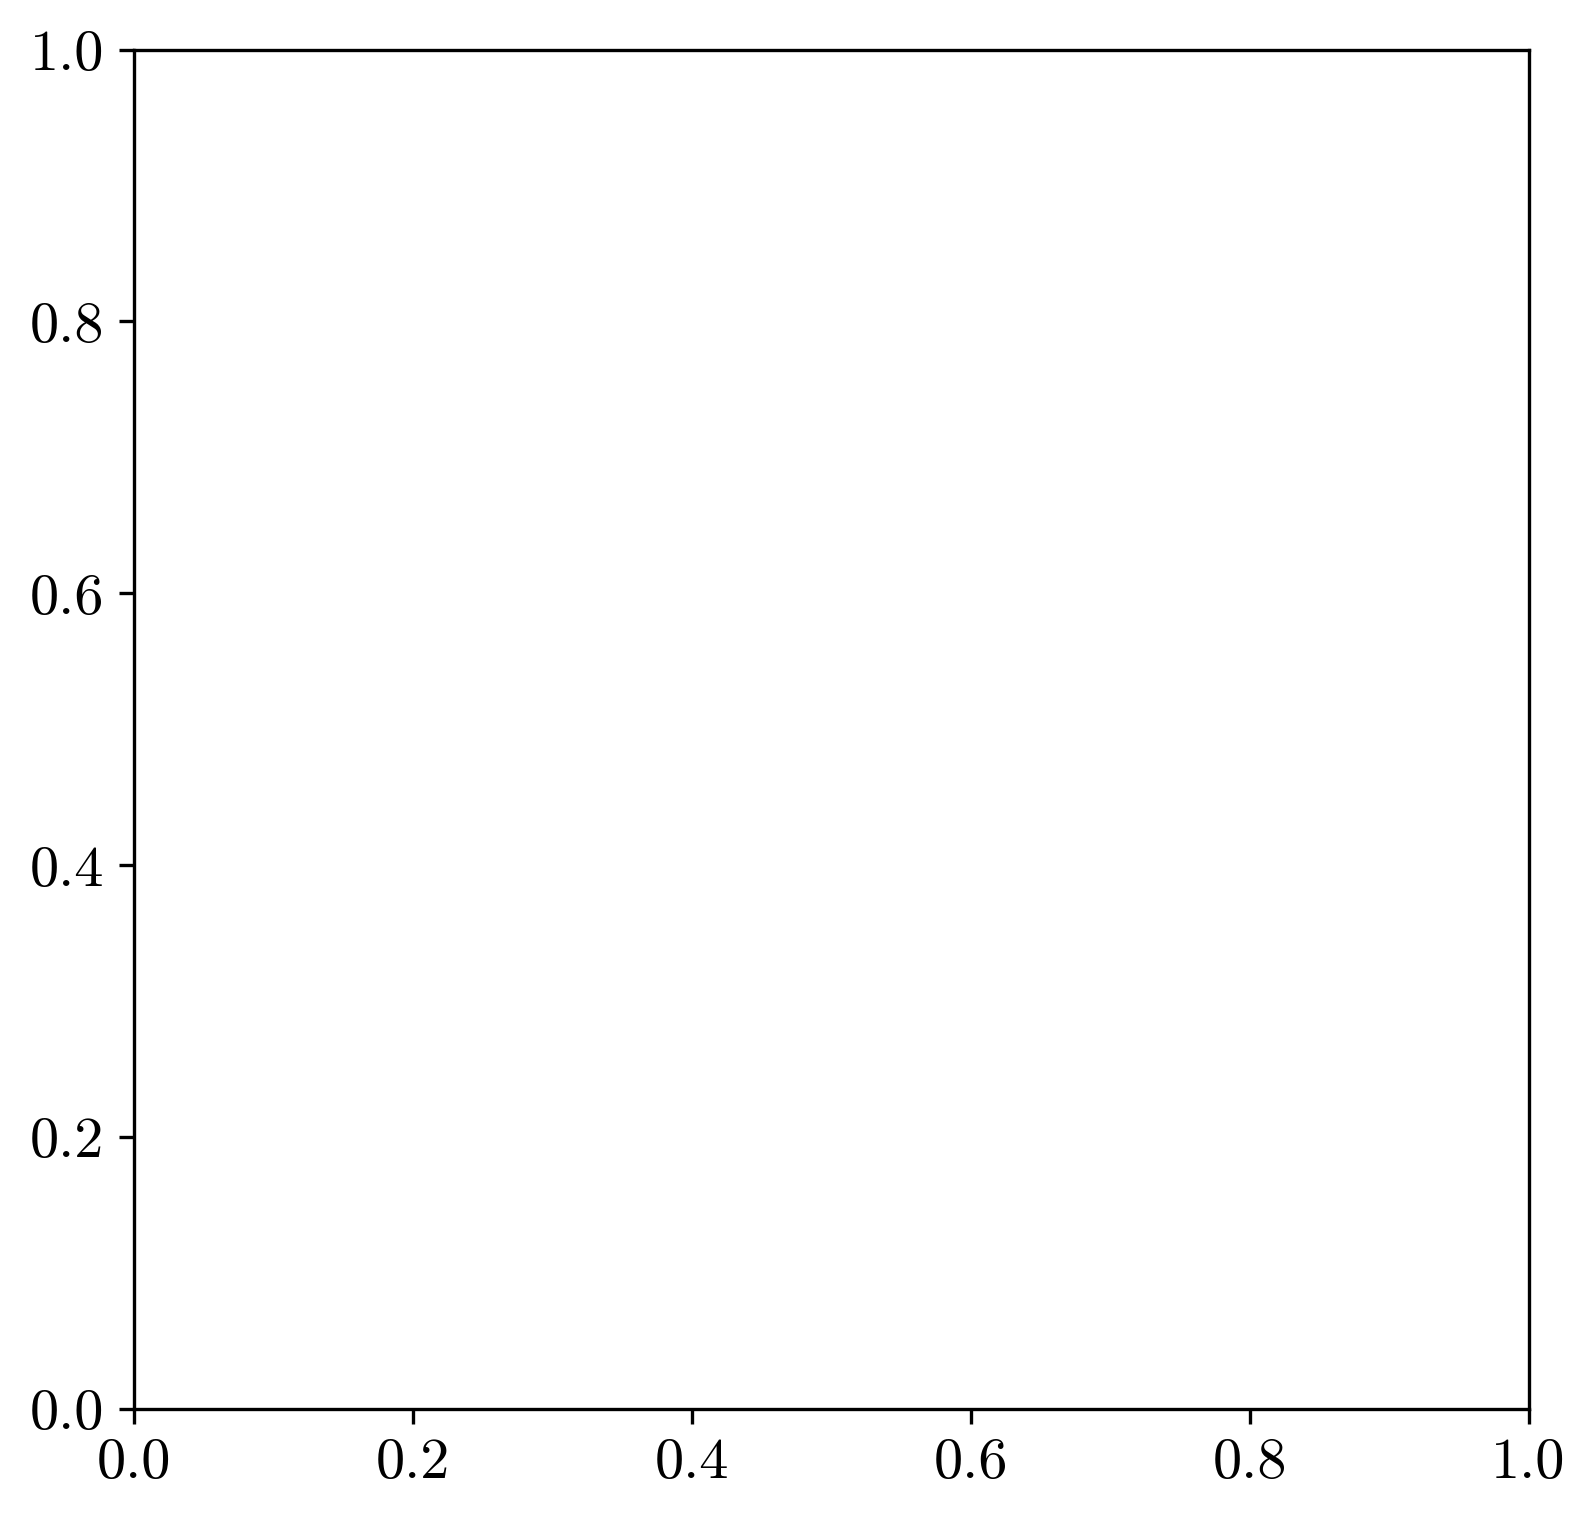

In [175]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

lines = []
xrange = [-100,120]
yrange = [-100,150]
for i in range(7):
    CS = plot_kde(ax, X_2d, predict_label, xrange, yrange, 1000, i, f'C{i}')
    lines.append(CS.collections[0])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.legend(lines, name_list, loc='lower right')
ax.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax.transAxes)    

#ax.set_title('t-SNE Embedding')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.png')    
#fig.savefig(f'../figures/paper_JHEP/t-SNE_SimulatedJet_ContourPlot.pdf')

In [33]:
namelist = name_list

In [34]:
namelist

['QCD', '2p25', '2p170', '3p25', '3p170', '4p170', '4p400']

In [32]:
colorlist = ['C0','C1','C2','C3','C4','C5','C6']

In [41]:
def plot_circle_and_fill_hist(embedding, npoints, extrafeats, label, ax_i, ax_j1, ax_j2, ax_j3, center, radius, color, whichlabel):
    bins = np.linspace(0,1,26)
    circle1 = Circle(center, radius, color=color, alpha=0.35)
    diff = embedding - np.tile(np.array(center), (npoints,1))
    dist = np.sqrt(np.sum(diff*diff, axis =1))
    indices = np.where(dist<radius)
    selected_feats = extrafeats[indices[0]]
    labelselected = label[indices[0]]
    ax_i.add_patch(circle1)
    
    #ax_j1.hist(selected_feats[:,8],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j1.hist(selected_feats[labelselected==i,8],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j1.set_xlabel(r'$\tau_{43}$', fontsize=20)
    ax_j1.set_ylabel(r'Density', fontsize=20)
    ax_j1.legend(fontsize=14)
    
    #ax_j2.hist(selected_feats[:,6],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j2.hist(selected_feats[labelselected==i,6],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j2.set_xlabel(r'$\tau_{21}$', fontsize=20)
    ax_j2.set_ylabel(r'Density', fontsize=20)
    ax_j2.legend(fontsize=14)
    
    
    #ax_j3.hist(selected_feats[:,7],density=True,alpha=0.3, label='original mixture',color='grey',bins=bins)
    for i in whichlabel:
        print(i, selected_feats[labelselected==i,-1].shape)
        if namelist[i] == 'QCD':
            alpha = 0.7
        else:
            alpha = 0.3
        ax_j3.hist(selected_feats[labelselected==i,7],density=True,alpha=alpha, label=f'Selected {namelist[i]}',color=colorlist[i],bins=bins)
    ax_j3.set_xlabel(r'$\tau_{32}$', fontsize=20)
    ax_j3.set_ylabel(r'Density', fontsize=20)
    ax_j3.legend(fontsize=14)

    return None

    

0 (101,)
1 (58,)
2 (89,)
3 (168,)
4 (179,)
5 (182,)
6 (17,)
0 (101,)
1 (58,)
2 (89,)
3 (168,)
4 (179,)
5 (182,)
6 (17,)
0 (101,)
1 (58,)
2 (89,)
3 (168,)
4 (179,)
5 (182,)
6 (17,)
0 (112,)
2 (186,)
4 (196,)
5 (229,)
6 (142,)
0 (112,)
2 (186,)
4 (196,)
5 (229,)
6 (142,)
0 (112,)
2 (186,)
4 (196,)
5 (229,)
6 (142,)
0 (89,)
2 (148,)
4 (110,)
5 (128,)
6 (116,)
0 (89,)
2 (148,)
4 (110,)
5 (128,)
6 (116,)
0 (89,)
2 (148,)
4 (110,)
5 (128,)
6 (116,)


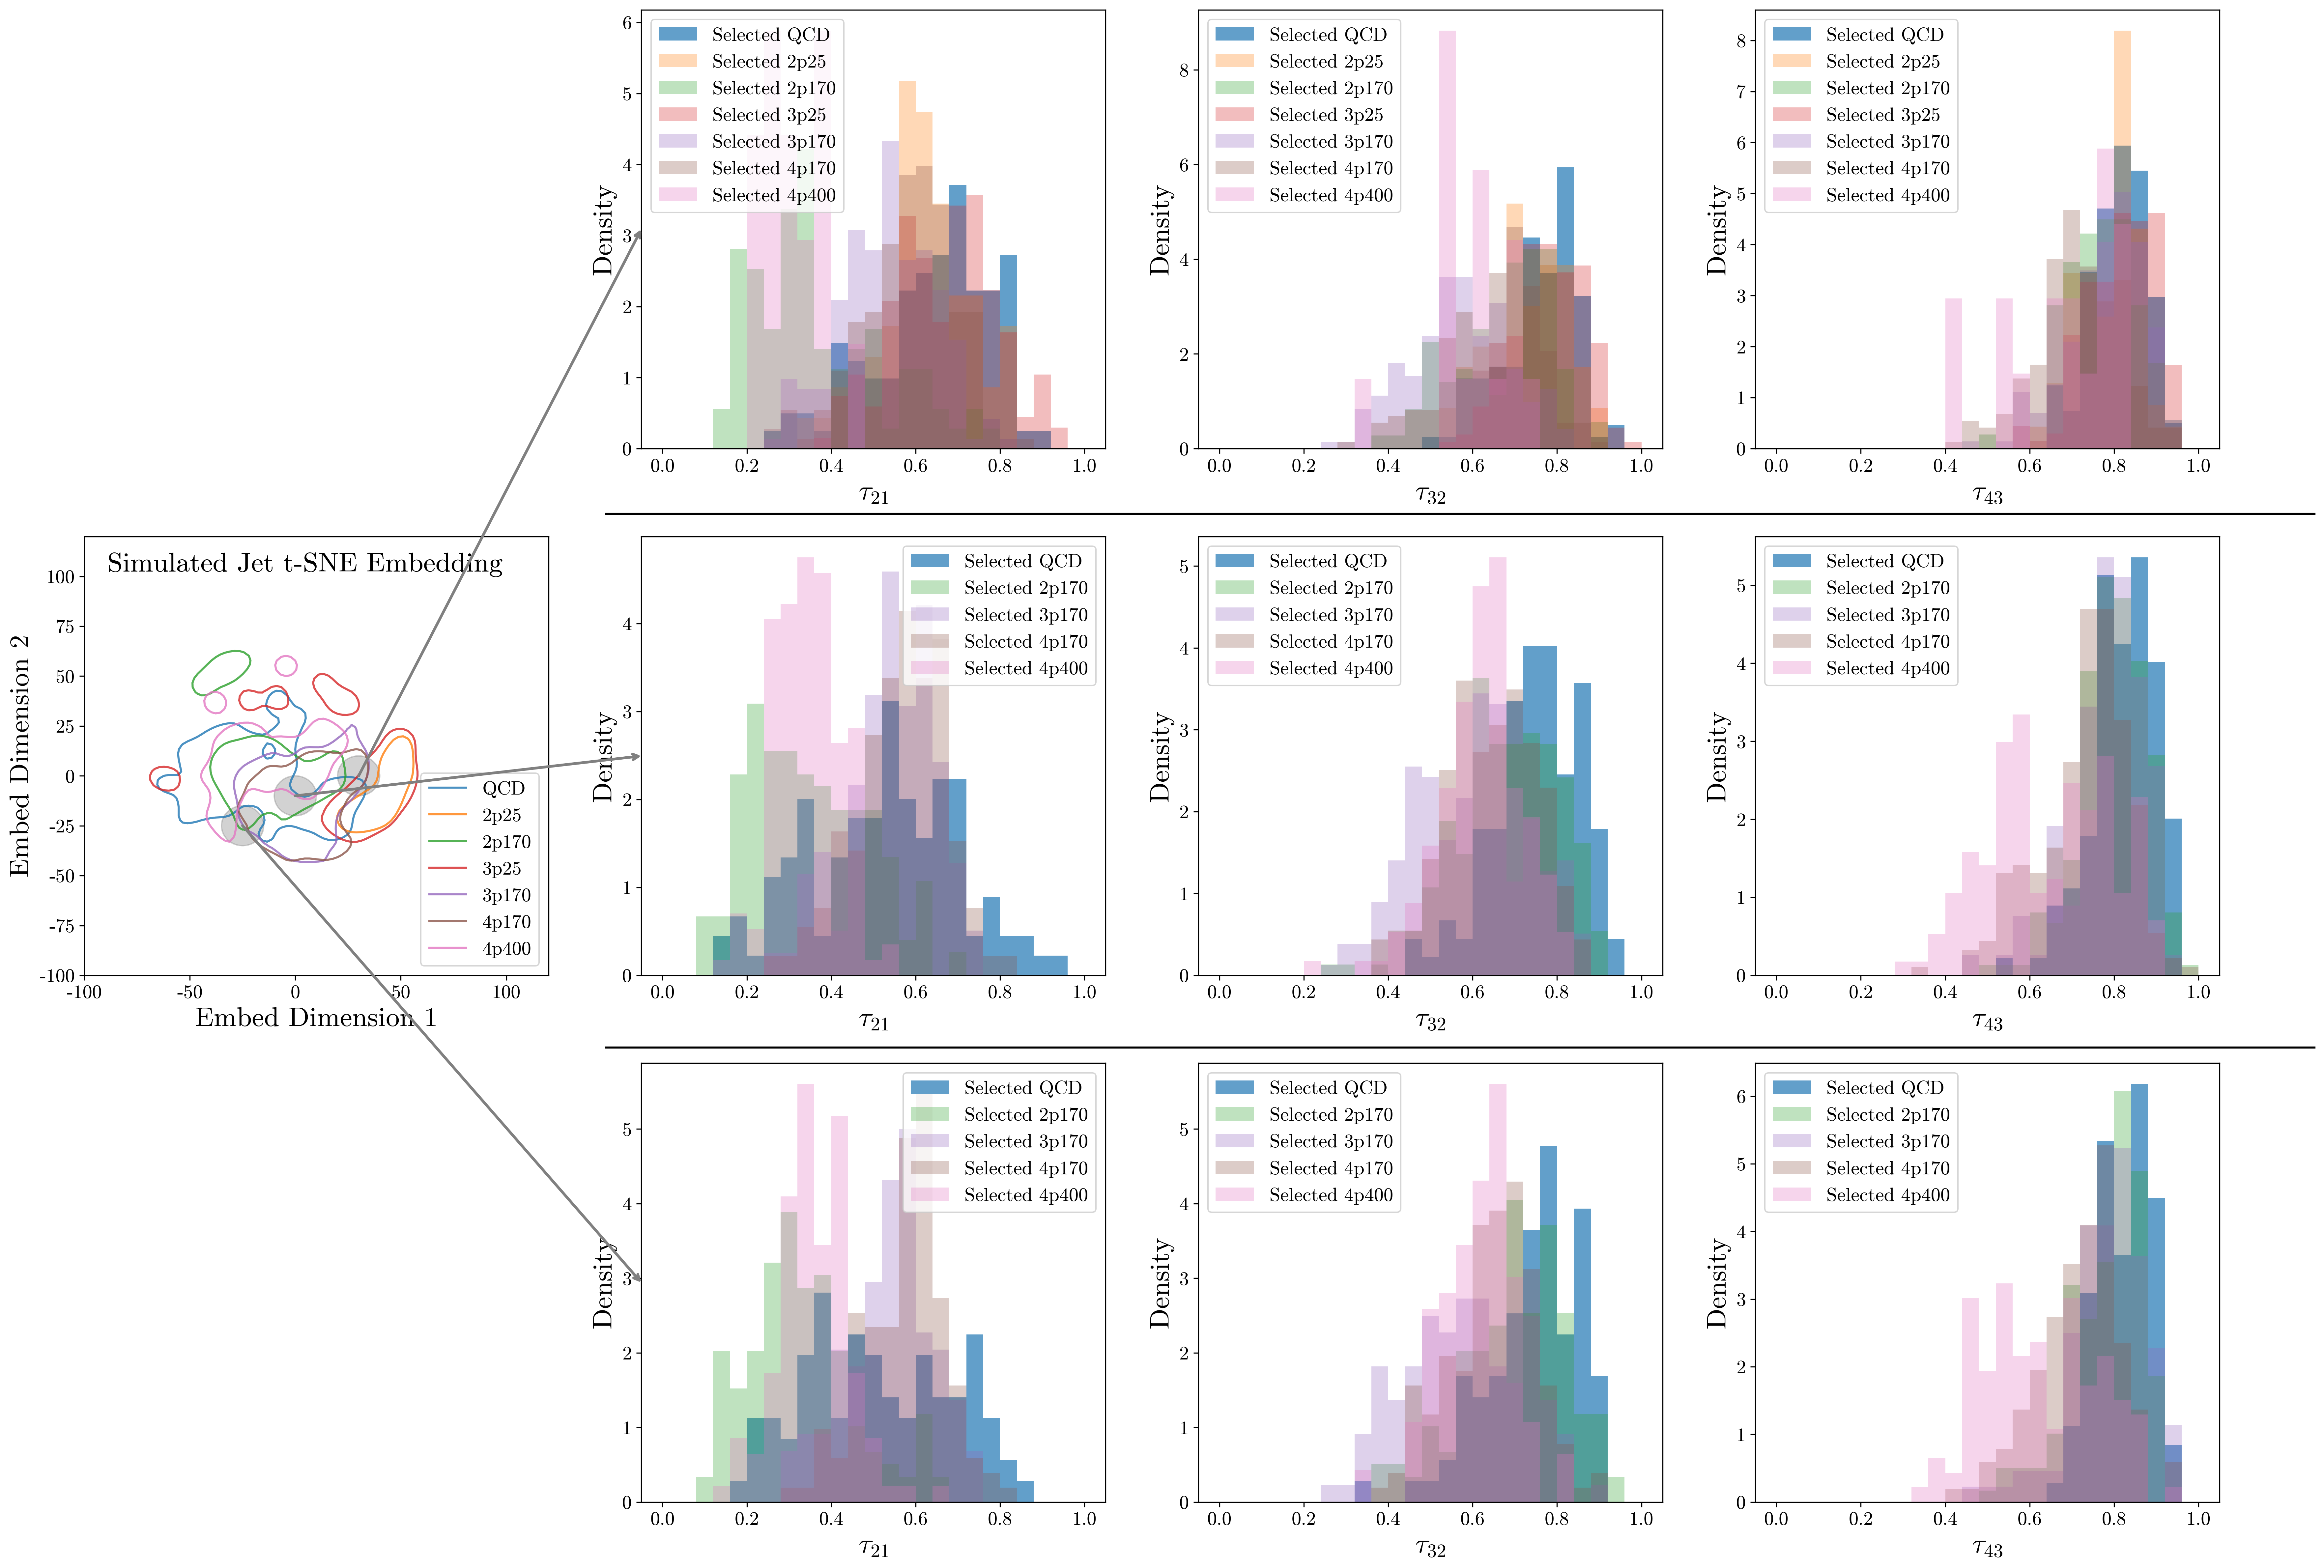

In [83]:
fig = plt.figure(constrained_layout=False, facecolor='1.',  figsize=(24,20))
gs = fig.add_gridspec(nrows=3, ncols=4, left=0.05, right=.95,
                      hspace=0.2, wspace=0.2)
ax0 = fig.add_subplot(gs[1, 0])
xrange = [-100,120]
yrange = [-100,120]

lines = []
for i in range(7):
    CS = plot_KDE_cdf_contour(ax0, X_2d, sliced_label, i, xrange, yrange, 5, [0.5], f'C{i}')
    lines.append(CS.collections[0])


ax0.set_xlabel('Embed Dimension 1', fontsize=20)
ax0.set_ylabel('Embed Dimension 2', fontsize=20)
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
ax0.legend(lines, namelist, loc='lower right')
ax0.text(.05,.92, 'Simulated Jet t-SNE Embedding',transform=ax0.transAxes, fontsize=20)    


ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 1])

ax3 = fig.add_subplot(gs[2, 1])

ax4 = fig.add_subplot(gs[0, 2])

ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[2, 2])

ax7 = fig.add_subplot(gs[0, 3])

ax8 = fig.add_subplot(gs[1, 3])

ax9 = fig.add_subplot(gs[2, 3])
plot_circle_and_fill_hist(X_2d, 21000, sliced_feats, sliced_label, ax0, ax7, ax1, ax4,  (30,0), 10,'grey',[0,1,2,3,4,5,6])
plot_circle_and_fill_hist(X_2d, 21000, sliced_feats, sliced_label, ax0, ax8, ax2, ax5,  (0,-10), 10,'grey',[0,2,4,5, 6])
plot_circle_and_fill_hist(X_2d, 21000, sliced_feats, sliced_label, ax0, ax9, ax3, ax6,  (-25,-25), 10,'grey',[0,2, 4,5,6])



con = ConnectionPatch(xyA=(30,0), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax1, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(0,-10), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax2, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(-25,-25), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax3, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)

ys = [0.355,0.625]
for y in ys:
    line = plt.Line2D([0.27,0.99],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

In [84]:
fig.savefig(f'../figures/paper_JHEP/t-SNE_WhatIsLearned.png')    
fig.savefig(f'../figures/paper_JHEP/t-SNE_WhatIsLearned.pdf')

In [50]:
fit = umap.UMAP(random_state=0)
#%time u = fit.fit_transform(results[:,:48])
%time u = fit.fit_transform(sliced_result)

CPU times: user 41.2 s, sys: 128 ms, total: 41.3 s
Wall time: 35.8 s


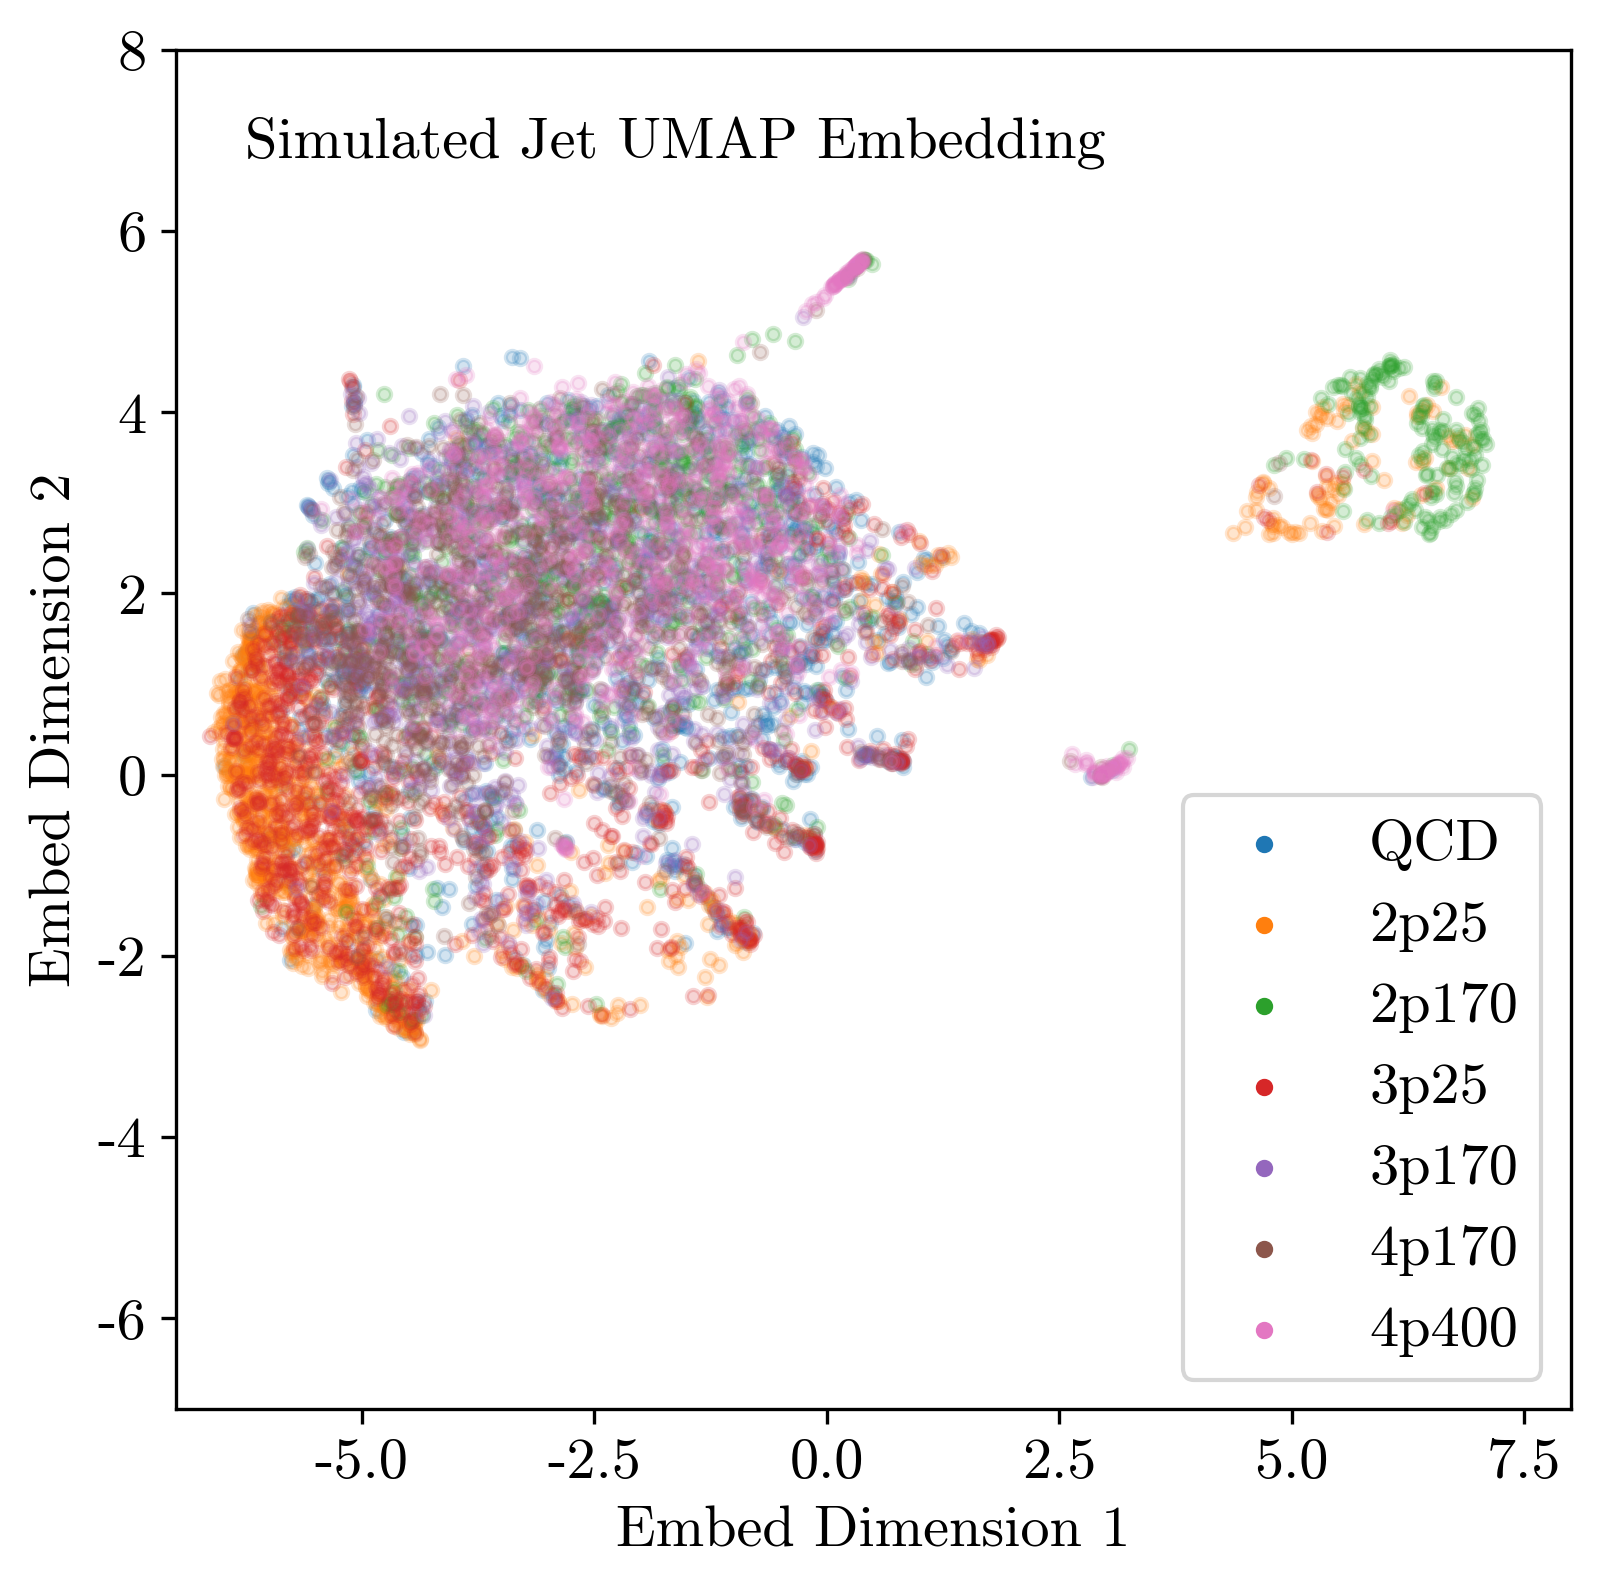

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(u[sliced_label==i][:1000,0],u[sliced_label==i][:1000,1],s=10,alpha=0.20,label=name_list[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-7,8])
ax.set_ylim([-7,8])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.text(.05,.92, 'Simulated Jet UMAP Embedding',transform=ax.transAxes)    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ScatterPlot.pdf')

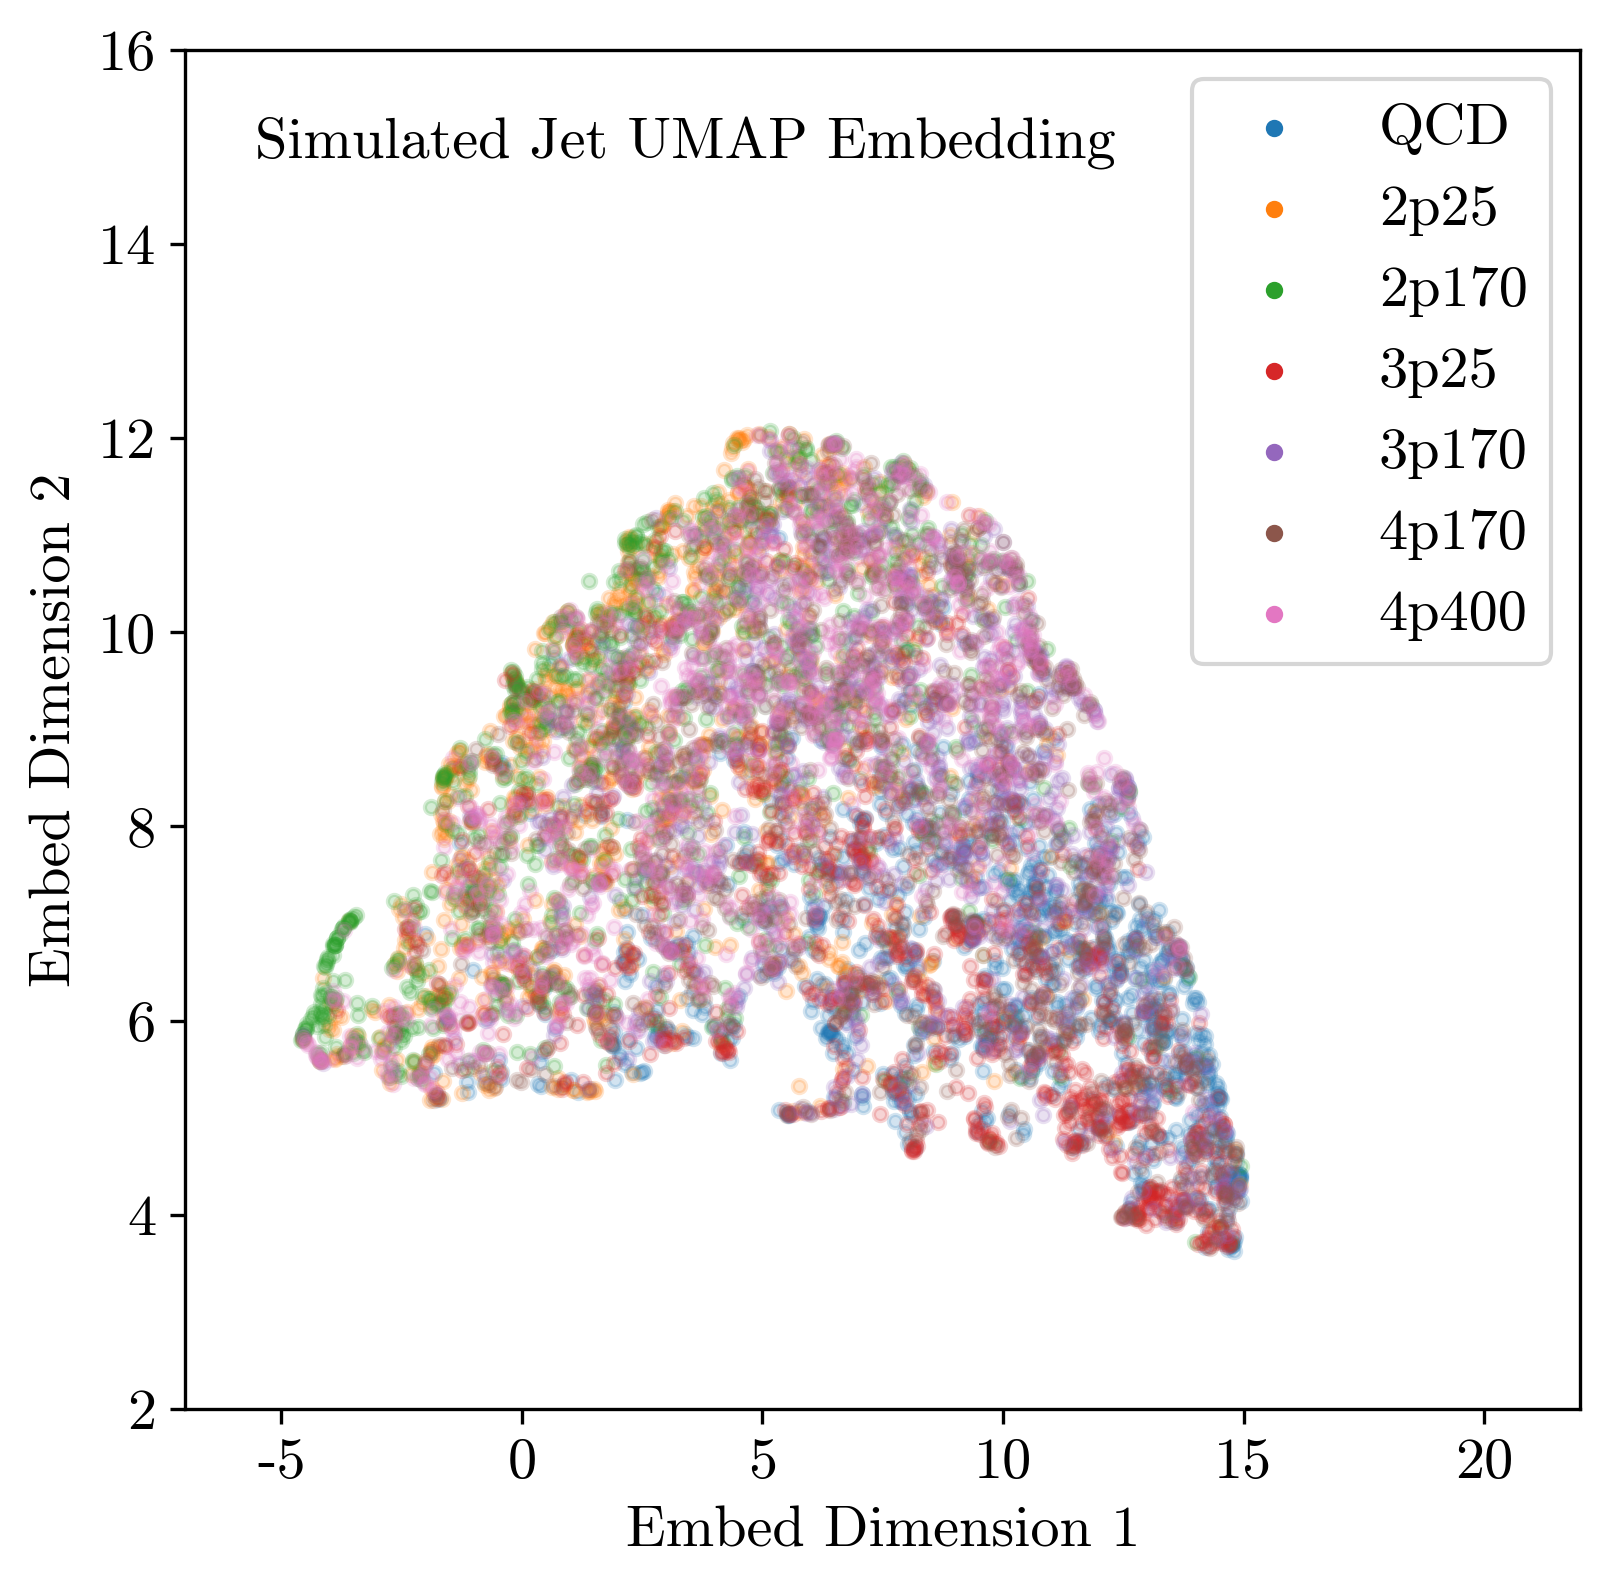

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(7):
    ax.scatter(u[predict_label==i][:1000,0],u[predict_label==i][:1000,1],s=10,alpha=0.20,label=name_list[i])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-7,22])
ax.set_ylim([2,16])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.text(.05,.92, 'Simulated Jet UMAP Embedding',transform=ax.transAxes)    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ScatterPlot.pdf')

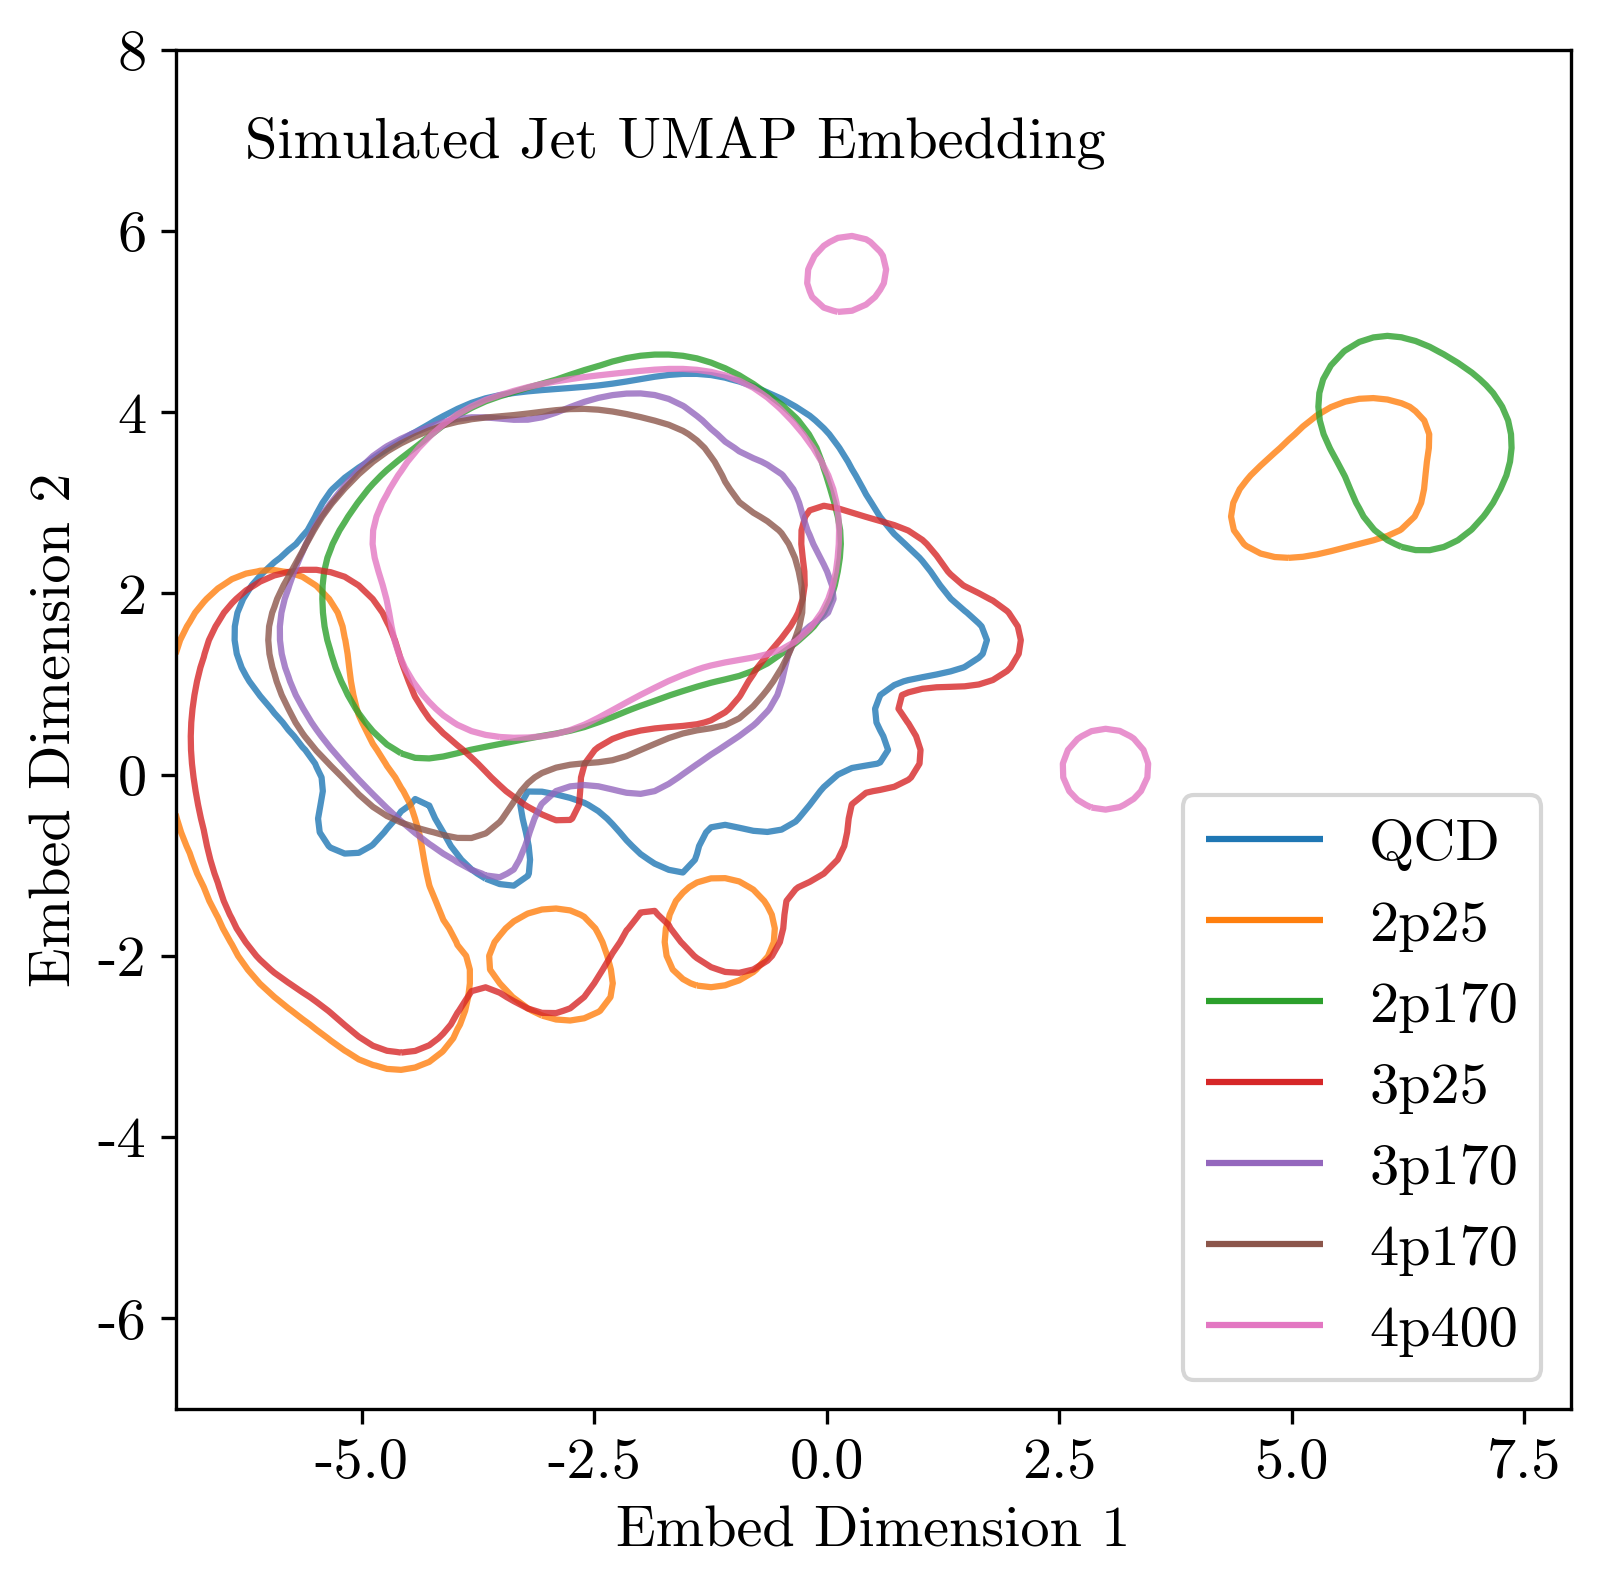

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
lines = []
xrange = [-7,8]
yrange = [-7,8]
for i in range(0,7):
    CS = plot_KDE_cdf_contour(ax, u, sliced_label, i, xrange, yrange, 0.4, [0.8], f'C{i}')
    lines.append(CS.collections[0])


ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
leg = ax.legend(lines, name_list, loc='lower right')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.text(.05,.92, 'Simulated Jet UMAP Embedding',transform=ax.transAxes)    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.pdf')    
    
    










0 (161,)
1 (34,)
3 (108,)
4 (63,)
5 (31,)
6 (98,)
0 (161,)
1 (34,)
3 (108,)
4 (63,)
5 (31,)
6 (98,)
0 (161,)
1 (34,)
3 (108,)
4 (63,)
5 (31,)
6 (98,)
0 (221,)
2 (73,)
3 (203,)
4 (155,)
5 (118,)
6 (46,)
0 (221,)
2 (73,)
3 (203,)
4 (155,)
5 (118,)
6 (46,)
0 (221,)
2 (73,)
3 (203,)
4 (155,)
5 (118,)
6 (46,)
0 (137,)
1 (286,)
2 (70,)
3 (425,)
4 (195,)
5 (213,)
0 (137,)
1 (286,)
2 (70,)
3 (425,)
4 (195,)
5 (213,)
0 (137,)
1 (286,)
2 (70,)
3 (425,)
4 (195,)
5 (213,)


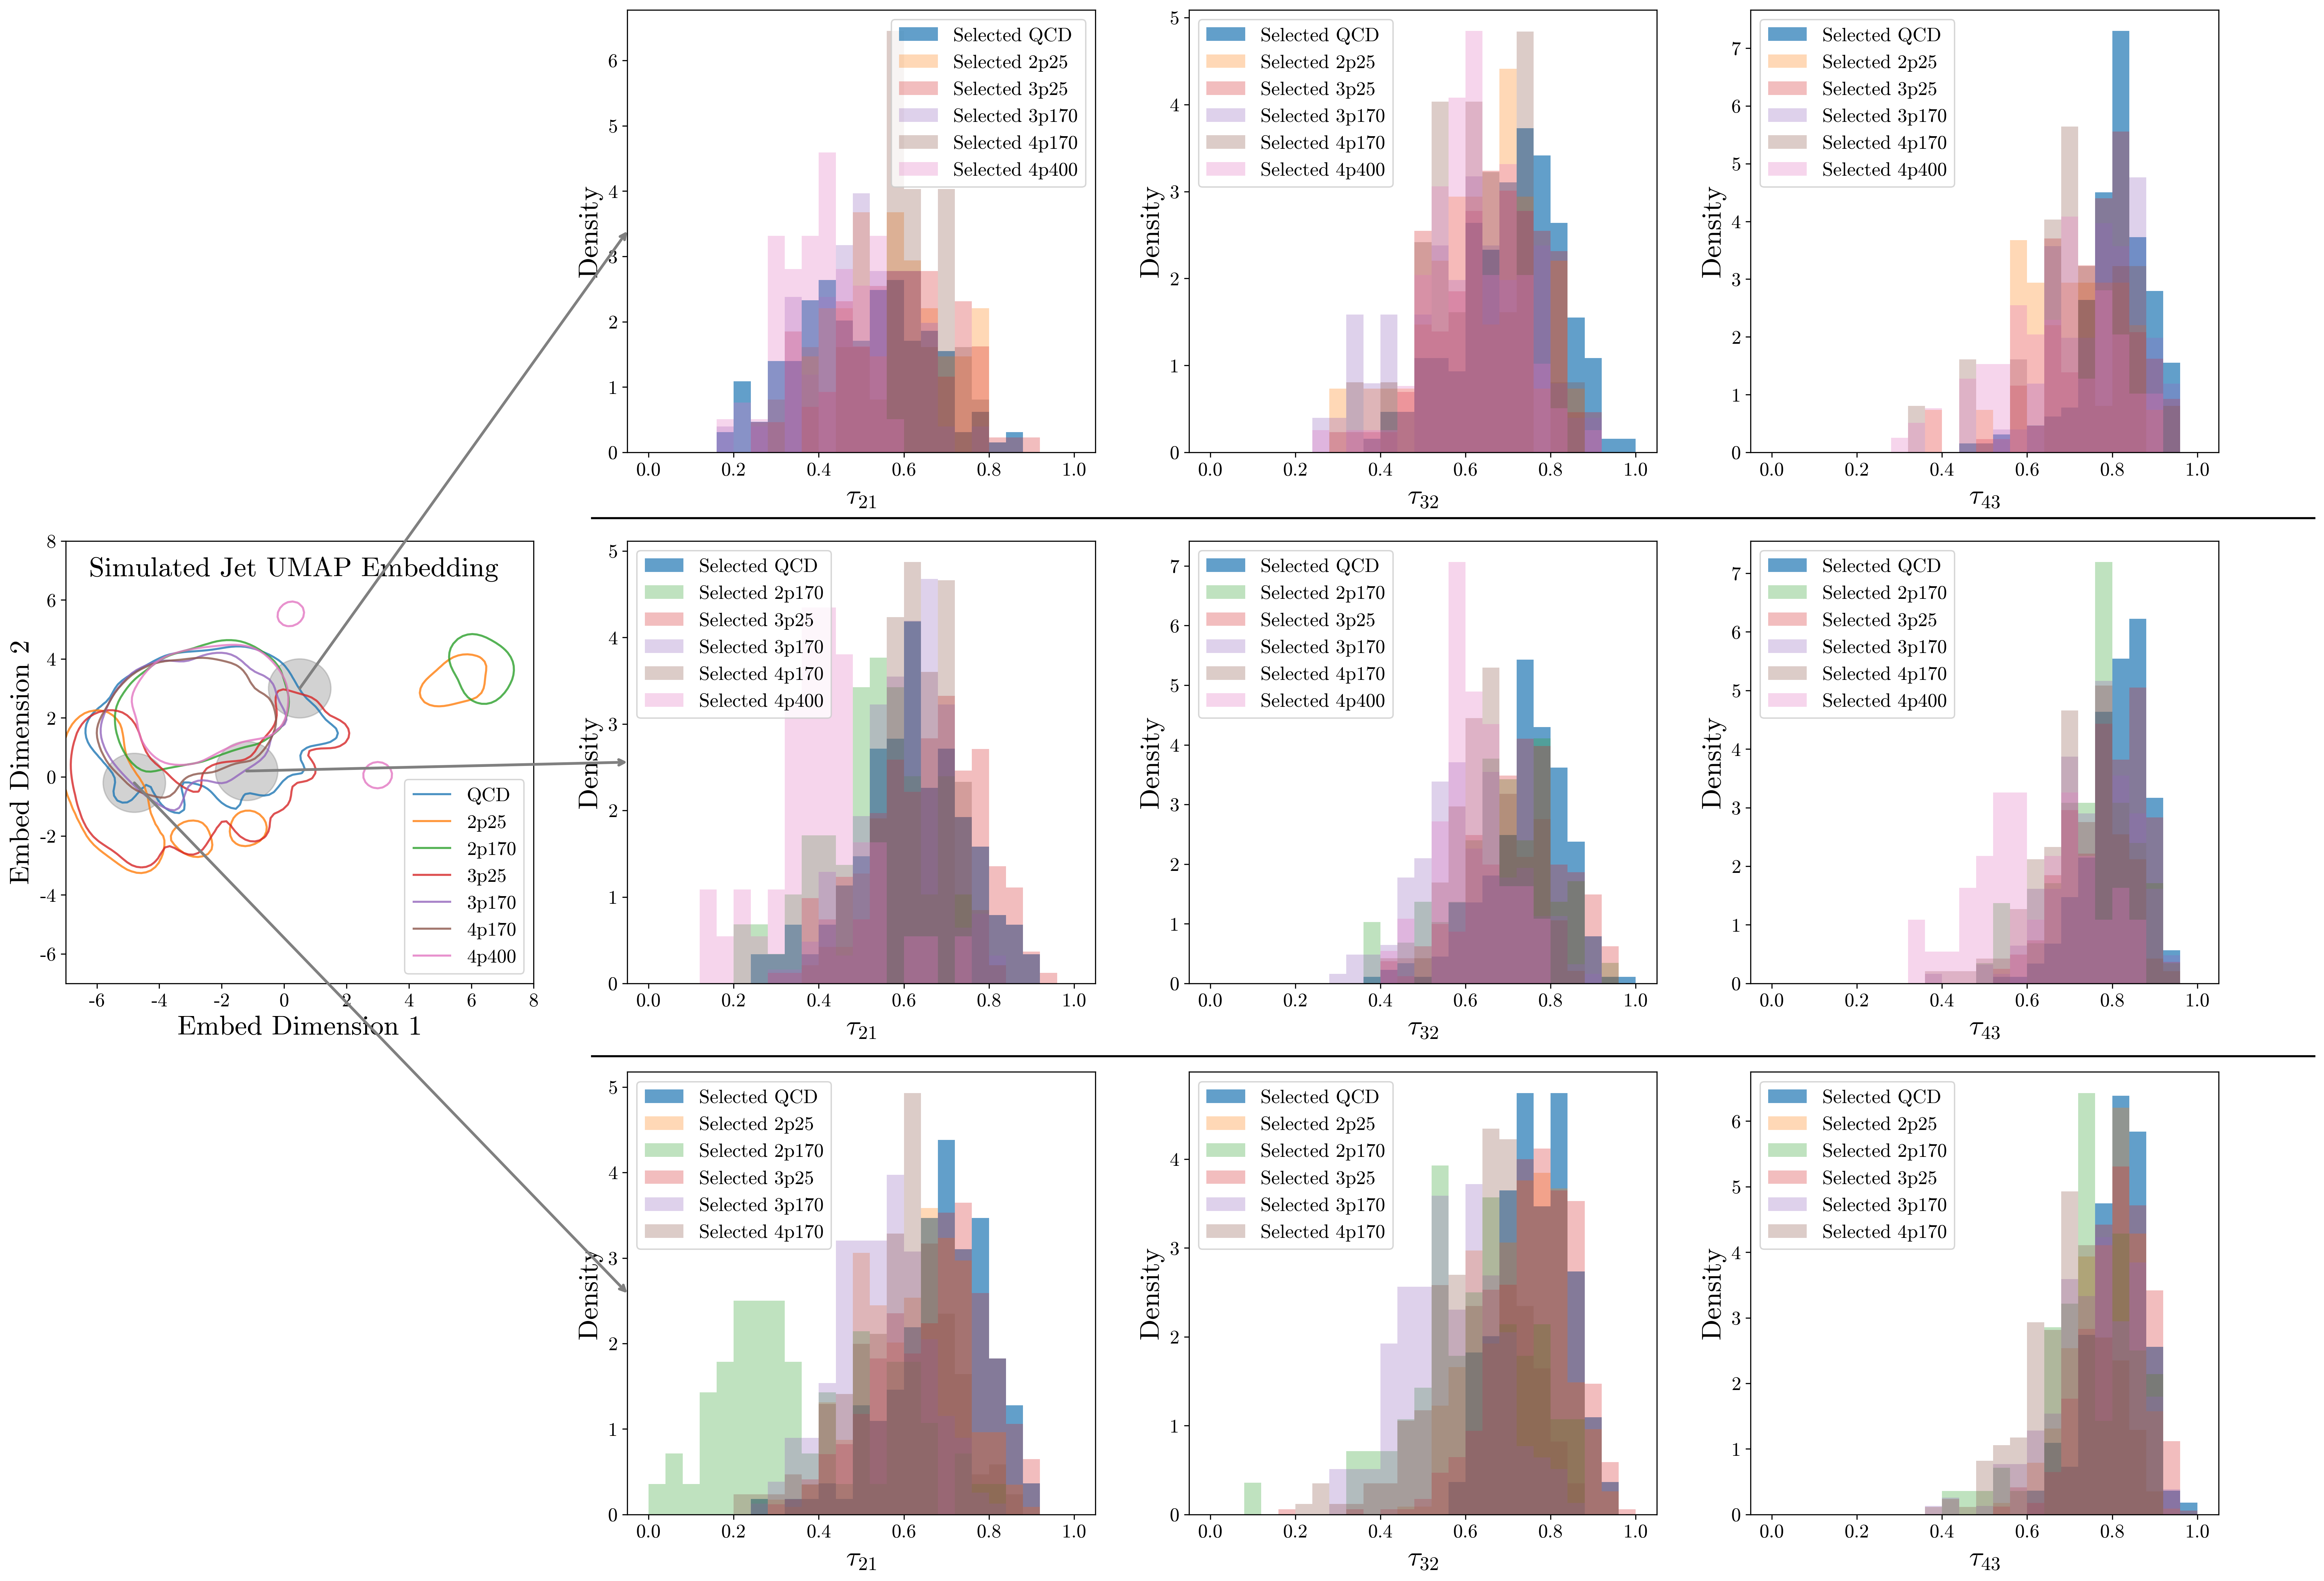

In [81]:
fig = plt.figure(constrained_layout=False, facecolor='1.',  figsize=(24,20))
gs = fig.add_gridspec(nrows=3, ncols=4, left=0.05, right=.95,
                      hspace=0.2, wspace=0.2)
ax0 = fig.add_subplot(gs[1, 0])

xrange = [-7,8]
yrange = [-7,8]

lines = []
for i in range(7):
    CS = plot_KDE_cdf_contour(ax0, u, sliced_label, i, xrange, yrange, 0.4, [0.8], f'C{i}')
    lines.append(CS.collections[0])


ax0.set_xlabel('Embed Dimension 1', fontsize=20)
ax0.set_ylabel('Embed Dimension 2', fontsize=20)
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
ax0.legend(lines, namelist, loc='lower right')
ax0.text(.05,.92, 'Simulated Jet UMAP Embedding',transform=ax0.transAxes, fontsize=20)    


ax1 = fig.add_subplot(gs[0, 1])

ax2 = fig.add_subplot(gs[1, 1])

ax3 = fig.add_subplot(gs[2, 1])

ax4 = fig.add_subplot(gs[0, 2])

ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[2, 2])

ax7 = fig.add_subplot(gs[0, 3])

ax8 = fig.add_subplot(gs[1, 3])

ax9 = fig.add_subplot(gs[2, 3])
plot_circle_and_fill_hist(u, 21000, sliced_feats, sliced_label, ax0, ax7, ax1, ax4,  (.5,3), 1,'grey',[0,1,3,4,5,6])
plot_circle_and_fill_hist(u, 21000, sliced_feats, sliced_label, ax0, ax8, ax2, ax5,  (-1.2,.2), 1,'grey',[0,2,3, 4,5, 6])
plot_circle_and_fill_hist(u, 21000, sliced_feats, sliced_label, ax0, ax9, ax3, ax6,  (-4.8,-.2), 1,'grey',[0,1,2,3, 4,5])



con = ConnectionPatch(xyA=(.5,3), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax1, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA= (-1.2,.2), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax2, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)
con = ConnectionPatch(xyA=(-4.8,-.2), xyB=(0,0.5), coordsA="data", coordsB="axes fraction",
                              axesA=ax0, axesB=ax3, color="grey", lw=2, arrowstyle='->')
fig.add_artist(con)

ys = [0.355,0.625]
for y in ys:
    line = plt.Line2D([0.27,0.99],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

In [82]:
fig.savefig(f'../figures/paper_JHEP/UMAP_WhatIsLearned.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_WhatIsLearned.pdf')

1.0 1.9962017659478416e-104
1.0 2.4801180903429234e-40
1.0 1.652244208500187e-51
1.0 2.18252661399157e-67
1.0 3.700066800459951e-52
1.0 1.9154471022027065e-45
1.0 6.290258049700703e-64


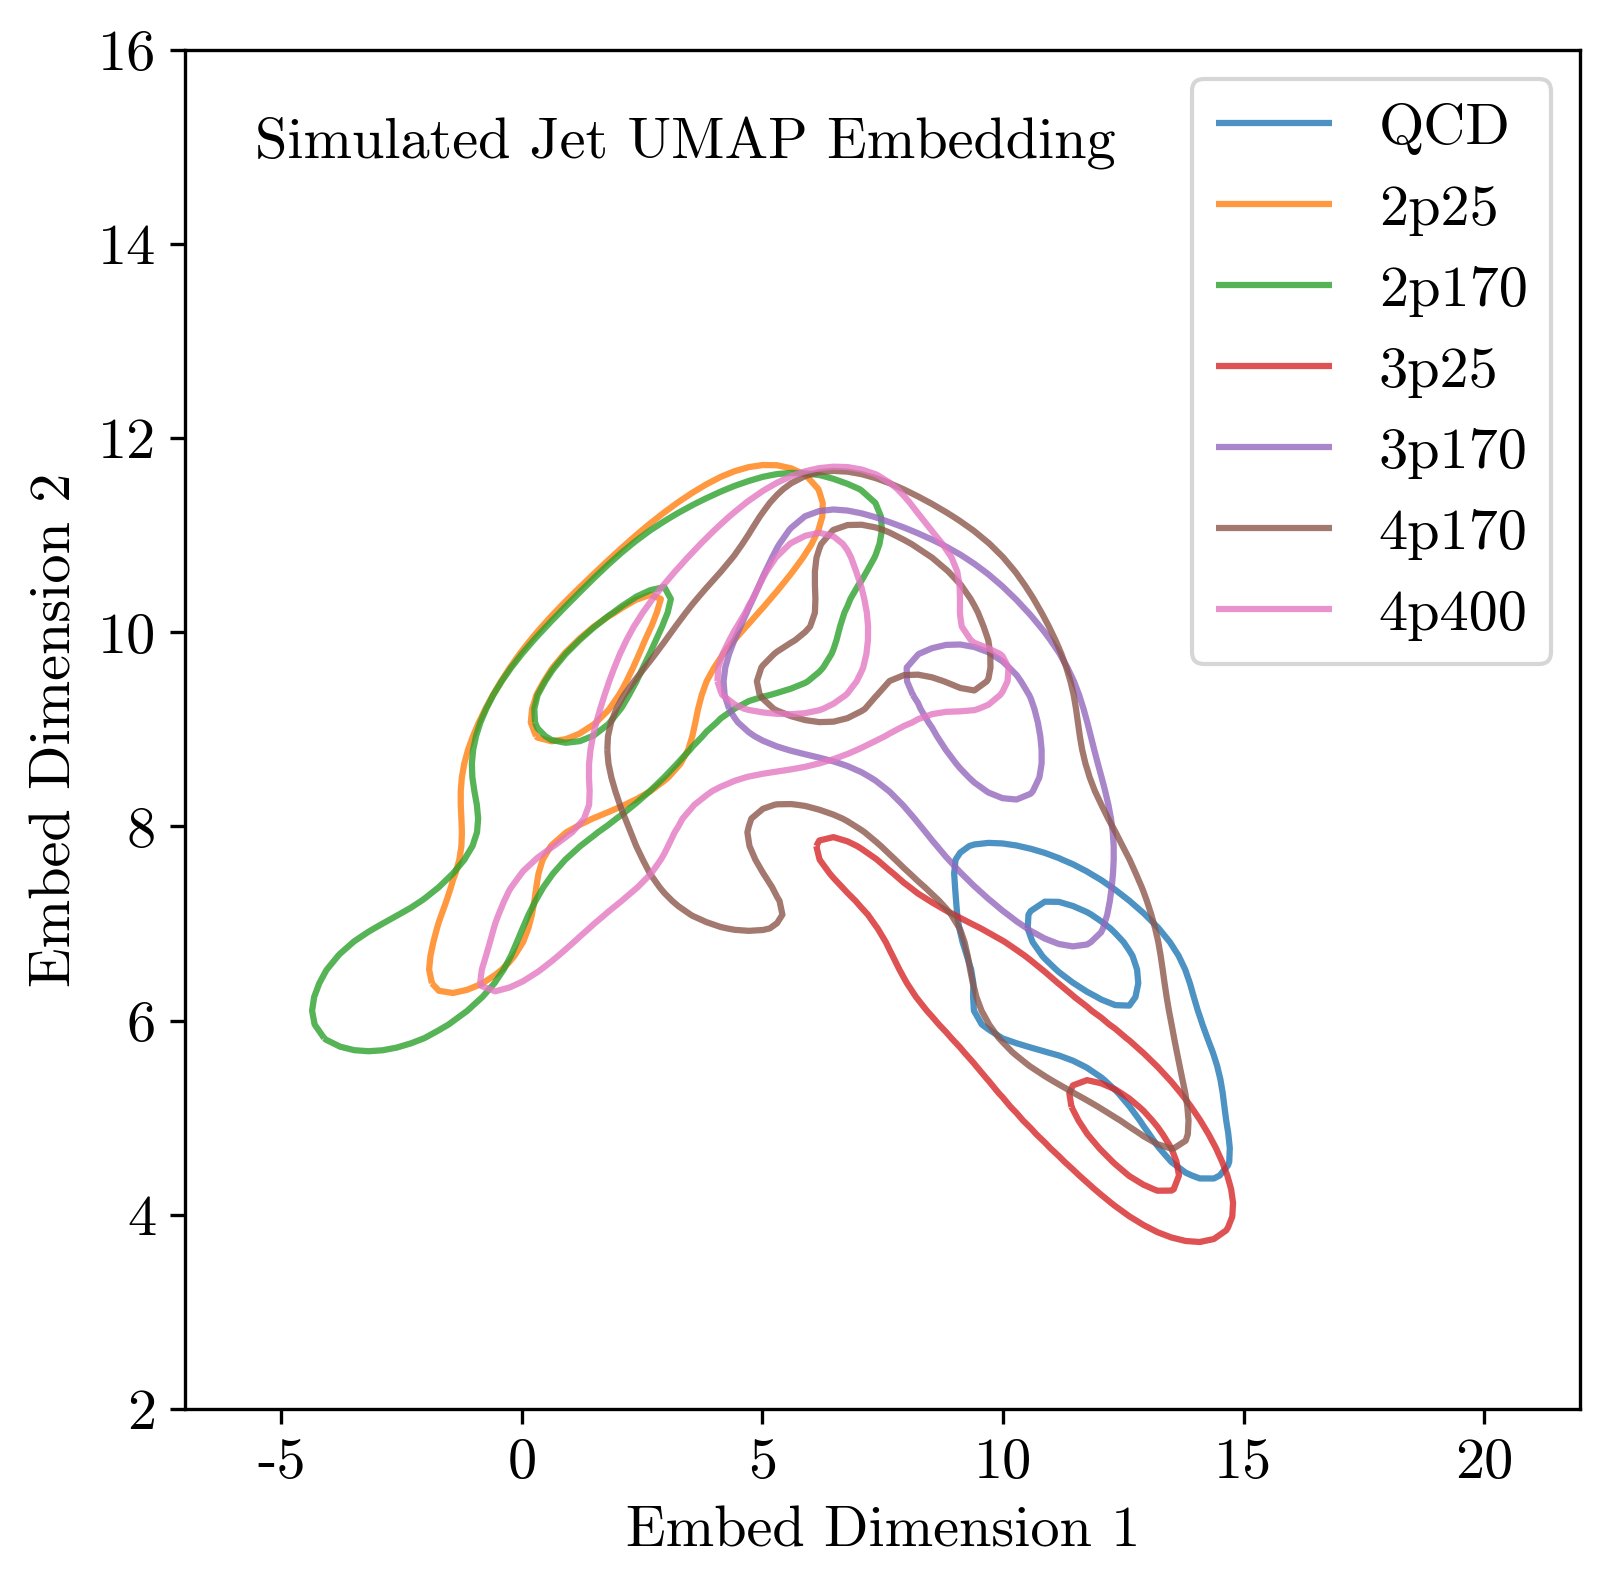

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

lines = []
xrange = [-7,22]
yrange = [2,16]
for i in range(7):
    CS = plot_kde(ax, u, predict_label, xrange, yrange, 1000, i, f'C{i}')
    lines.append(CS.collections[0])

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.legend(lines, name_list)
ax.text(.05,.92, 'Simulated Jet UMAP Embedding',transform=ax.transAxes)    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.png')    
fig.savefig(f'../figures/paper_JHEP/UMAP_SimulatedJet_ContourPlot.pdf')

In [ ]:
model = ManifoldEmbedder.load_from_checkpoint("./simulatedtoyjets_checkpoints/Transformer-paper-v0-checkpoint-epoch=01-val_loss=0.55.ckpt")
model.eval()